## Imports

In [23]:
import os
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import lit
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import threading 
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score, f1_score

import seaborn as sns

## start Session

In [2]:
spark_home="C:/Users/Lenovo/Downloads/spark_unzipped"
os.environ["SPARK_HOME"] = spark_home

# Add Spark bin and executors to PATH
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "bin")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "sbin")

# Add Spark Python libraries to PYTHONPATH
os.environ["PYTHONPATH"] = os.path.join(spark_home, "python") + os.pathsep + os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] += os.pathsep + os.path.join(spark_home, "python", "lib")

# Add PySpark to the system path
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "pyspark.zip")
os.environ["PATH"] += os.pathsep + os.path.join(spark_home, "python", "lib", "py4j-0.10.9-src.zip")

os.environ['PYSPARK_DRIVER_PYTHON'] = 'jupyter'
os.environ['PYSPARK_DRIVER_PYTHON_OPTS'] = 'lab'
os.environ['PYSPARK_PYTHON'] = 'python'

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("PySpark-Script") \
    .getOrCreate()

# PreProcessing

In [4]:
dataset = spark.read.csv("dataset.csv", header=True, inferSchema=True)
dataset = dataset.drop("_c83")
dataset.printSchema()
print(dataset.count())
# print(dataset.rdd)

root
 |-- encounter_id: integer (nullable = true)
 |-- patient_id: integer (nullable = true)
 |-- hospital_id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- elective_surgery: integer (nullable = true)
 |-- ethnicity: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- height: double (nullable = true)
 |-- icu_admit_source: string (nullable = true)
 |-- icu_id: integer (nullable = true)
 |-- icu_stay_type: string (nullable = true)
 |-- icu_type: string (nullable = true)
 |-- pre_icu_los_days: double (nullable = true)
 |-- weight: double (nullable = true)
 |-- apache_2_diagnosis: integer (nullable = true)
 |-- apache_3j_diagnosis: double (nullable = true)
 |-- apache_post_operative: integer (nullable = true)
 |-- arf_apache: integer (nullable = true)
 |-- gcs_eyes_apache: integer (nullable = true)
 |-- gcs_motor_apache: integer (nullable = true)
 |-- gcs_unable_apache: integer (nullable = true)
 |-- gcs_verbal_apache

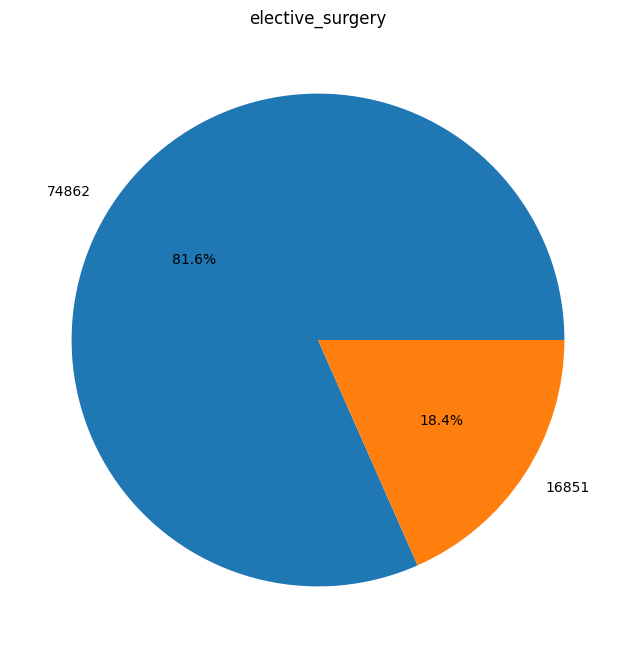

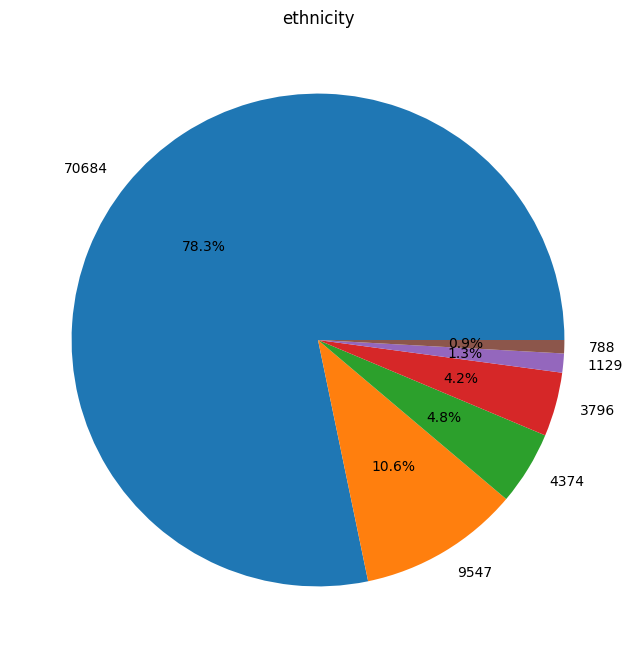

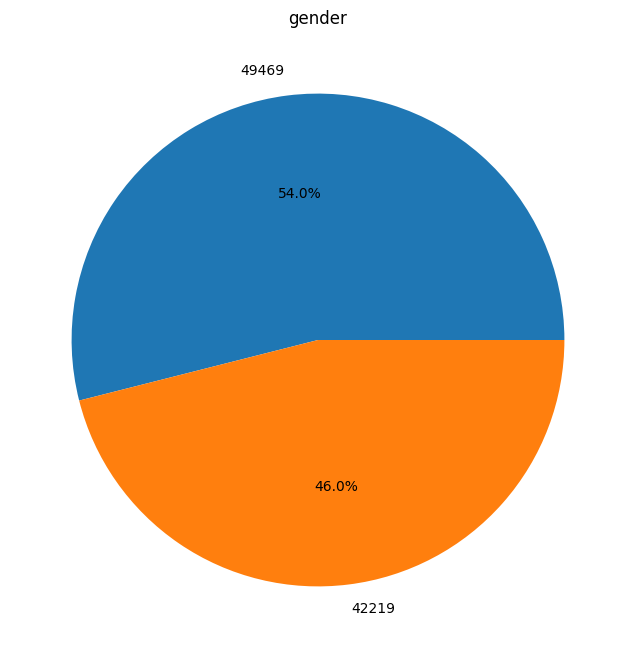

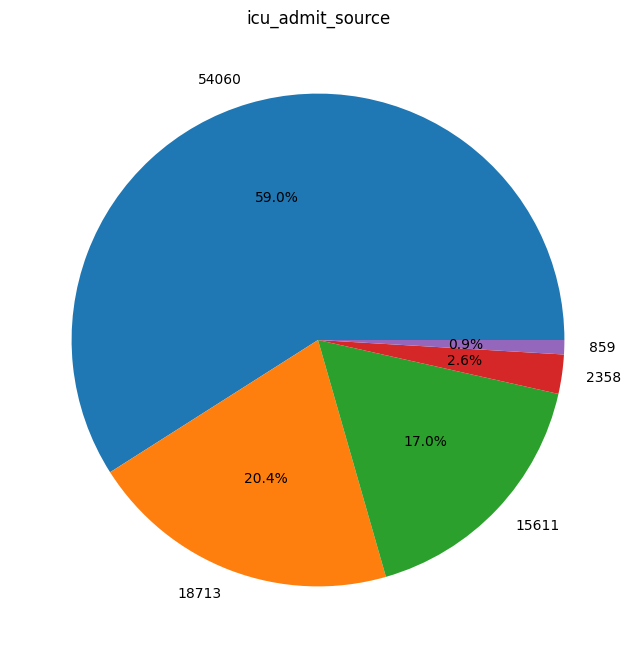

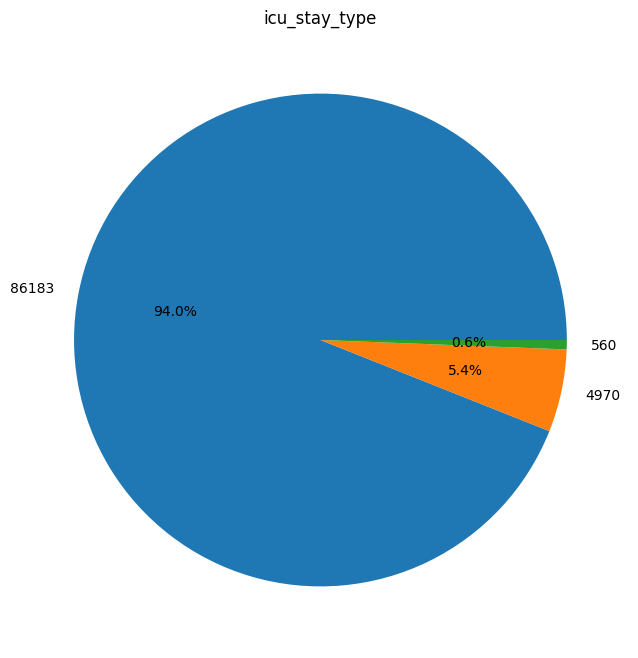

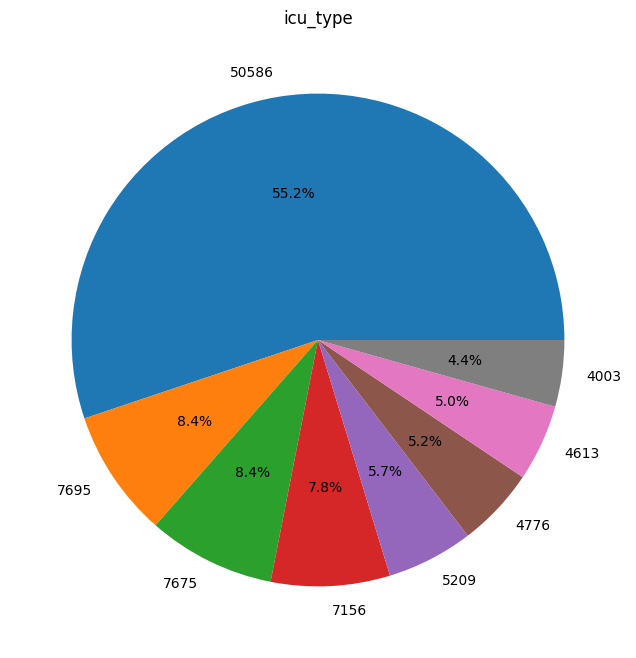

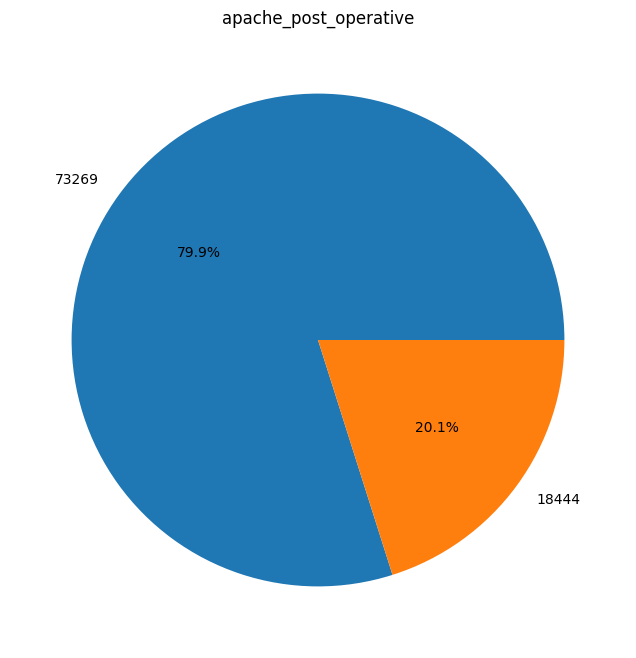

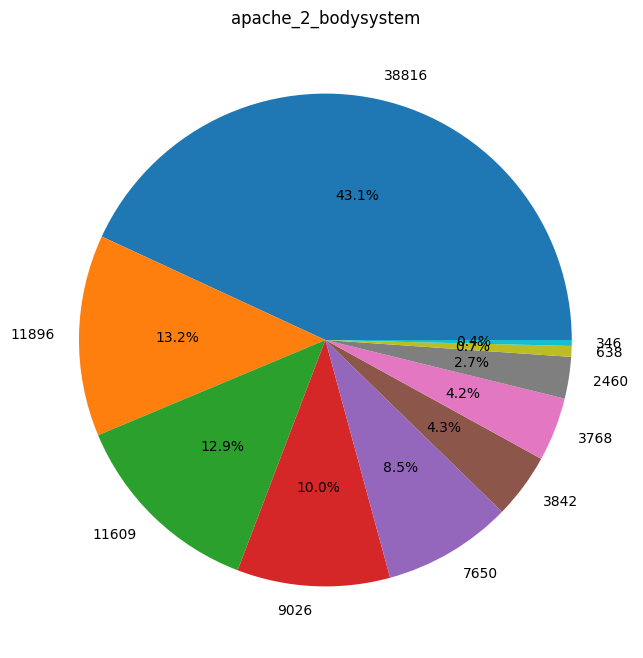

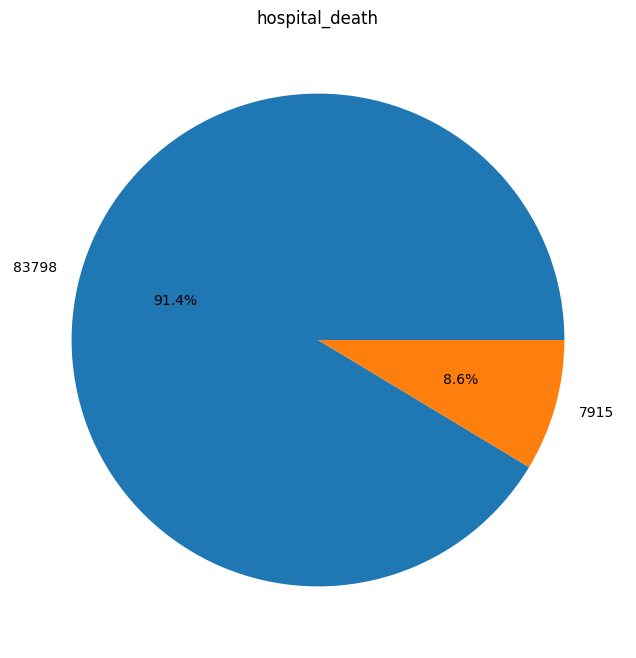

In [60]:
pandasds= dataset.toPandas()
for col_name, dtype in pandasds.dtypes.items():
    if dtype != 'int64' and dtype != 'float64':
        value_counts = pandasds[col_name].value_counts()
        if len(value_counts) <= 10:
            plt.figure(figsize=(8, 8))
            plt.pie(value_counts, labels=value_counts.values, autopct='%1.1f%%')
            plt.title(col_name)
            plt.show()


## Data Clearning with Map Reduce

In [5]:
'''
Data Cleaning:
1) Removing missing data/ N/A / unexpected values --> Done
2) dealing with outliers --> Done
3) data normalization/standardization -->  
4) transform features to categorial if needed --> Done
5) visualizing the data using plots(box/scatter/histograms ...etc) --> Done
'''

def preprocess_map(chunk):

    chunk_without_na = chunk.na.drop(how='any')

   
    chunk_without_outliers = chunk_without_na.filter(chunk_without_na['apache_4a_icu_death_prob'] >= 0)
    chunk_without_outliers = chunk_without_outliers.filter(chunk_without_outliers['apache_4a_hospital_death_prob'] >= 0)
    chunk_without_outliers = chunk_without_outliers.drop(*['encounter_id', 'patient_id', 'hospital_id', 'icu_id'])

    string_cols = [name for name, dtype in chunk_without_outliers.dtypes if dtype == "string"]
    for col_name in string_cols:
       
        col_unique_values = chunk_without_outliers.select(col_name).distinct()
        if col_unique_values.count() > 2:
            for col_value in col_unique_values.collect():
                chunk_without_outliers = chunk_without_outliers.withColumn(col_value[0], (chunk_without_outliers[col_name] == col_value[0]).cast("int"))
            chunk_without_outliers = chunk_without_outliers.drop(col_name)
        else:
            chunk_without_outliers = chunk_without_outliers.withColumn(col_name, (chunk_without_outliers[col_name] == 'F').cast("int"))



    return (1, chunk_without_outliers) 


def preprocess_reduce(accumulator, chunk):

    if accumulator is None:
        accumulator = chunk
    else:
        accumulator = accumulator.union(chunk)

    return accumulator



def my_map(func, iterable):
    mapped_iterable = []
    for item in iterable:
        mapped_item = func(item)
        mapped_iterable.append(mapped_item)
    return mapped_iterable


def my_reduce(func, iterable):
    result = iterable[0][1] 
    for _, item in iterable[1:]:
        result = func(result, item)
    return result



num_chunks = 4
chunks = dataset.randomSplit([1.0] * num_chunks)

mapped_results = my_map(preprocess_map, chunks)
dataset_without_na = my_reduce(preprocess_reduce, mapped_results)

dataset_without_na.show()
dataset_converted = dataset_without_na.toPandas()



+---+-----------+----------------+------+------+----------------+------+------------------+-------------------+---------------------+----------+---------------+----------------+-----------------+-----------------+-----------------+----------------+----------+---------------+-----------+-----------------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+-----------+-----------+-------------+-------------+-------------------------+-------------------------+----------------+----------------+----------+----------+----------------------+----------------------+---------------+---------------+-----------+-----------+------------+------------+------------------------+------------------------+--------------+--------------+-------------

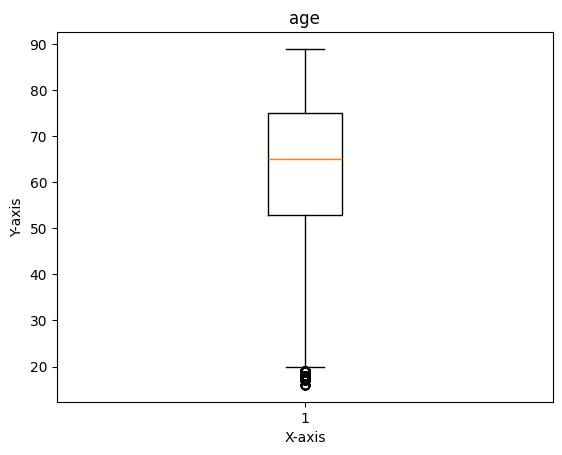

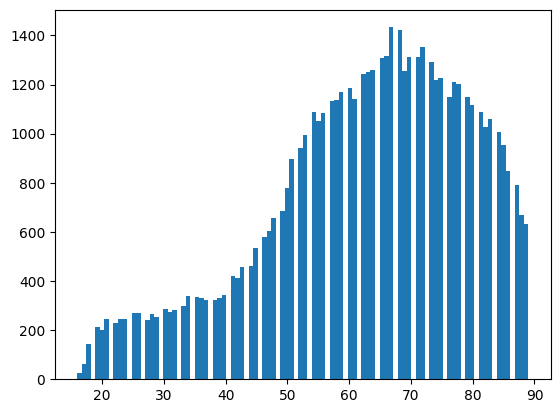

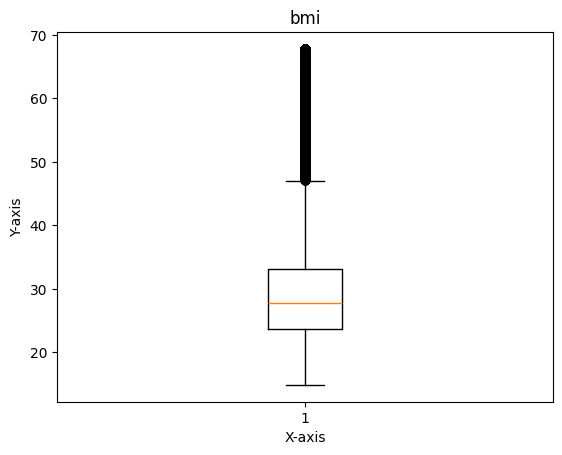

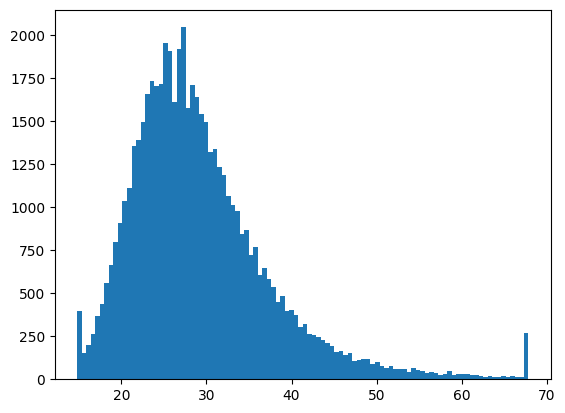

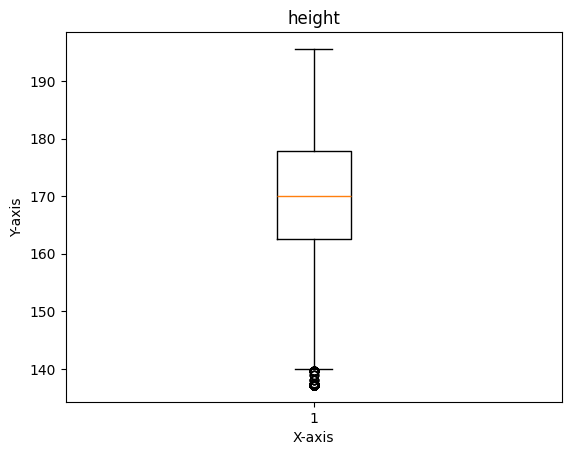

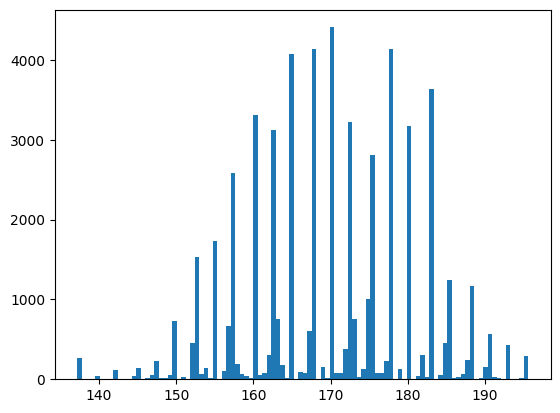

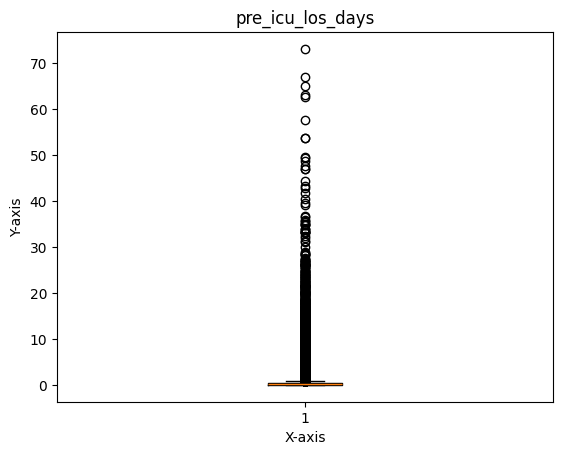

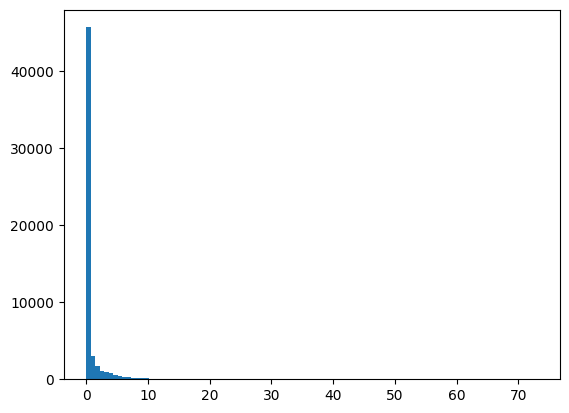

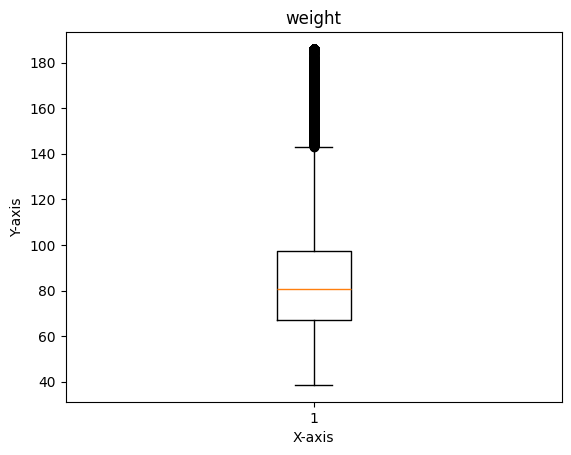

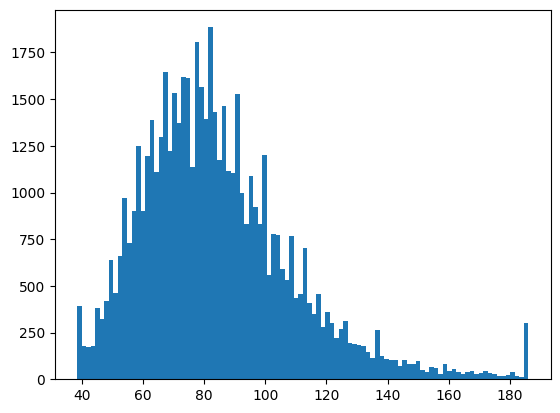

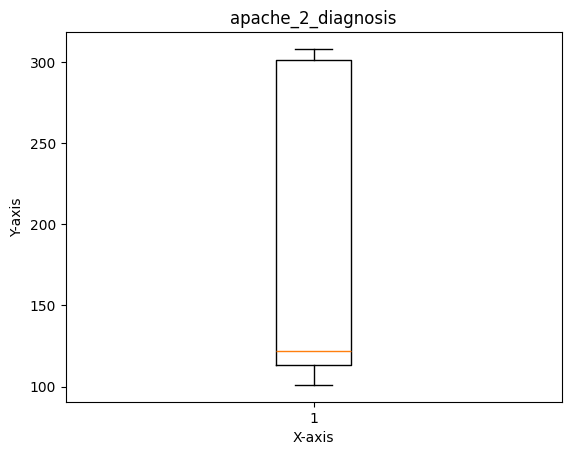

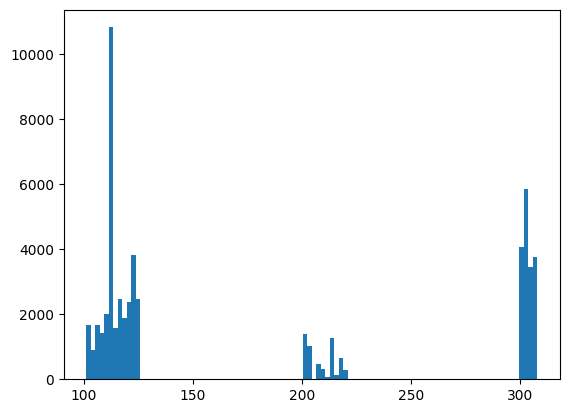

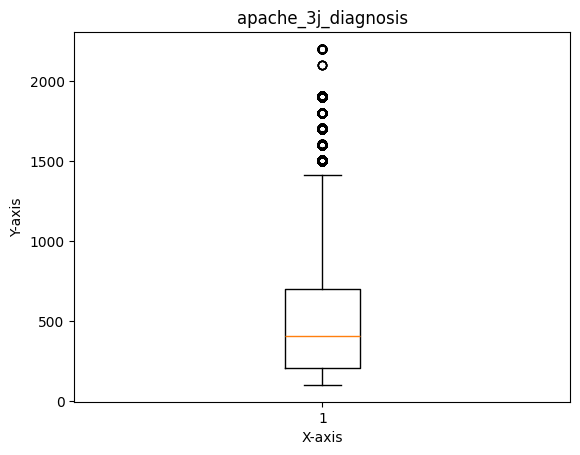

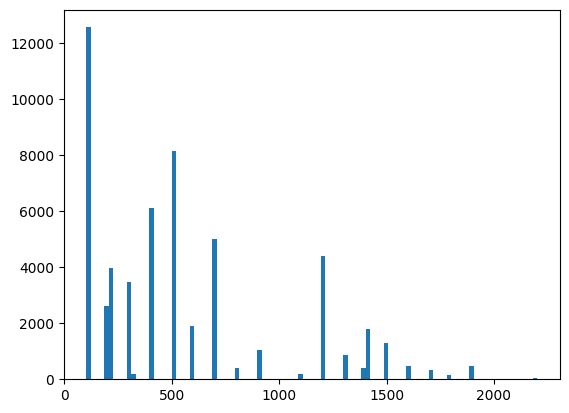

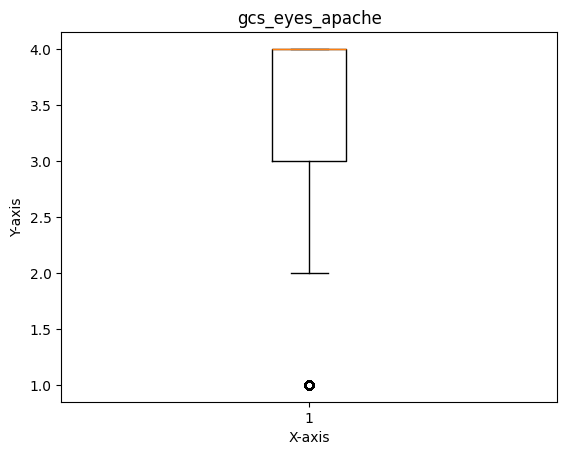

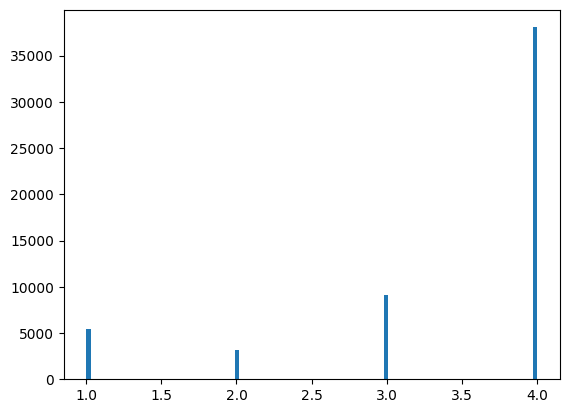

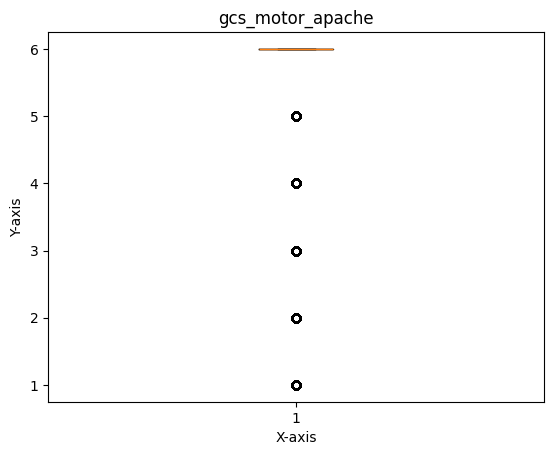

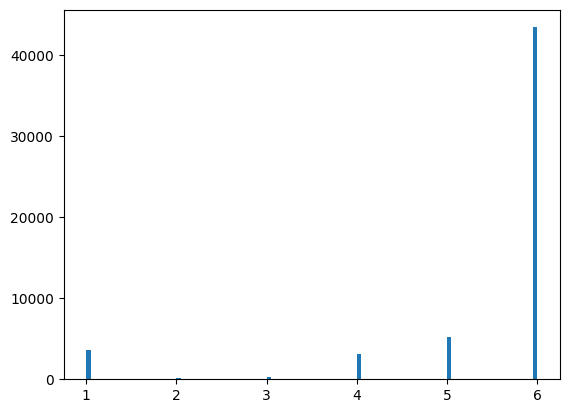

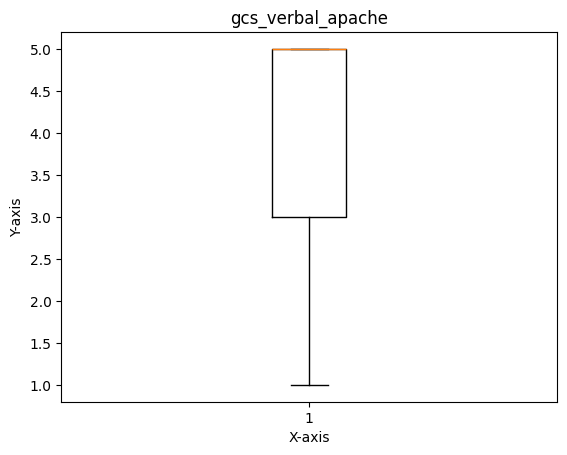

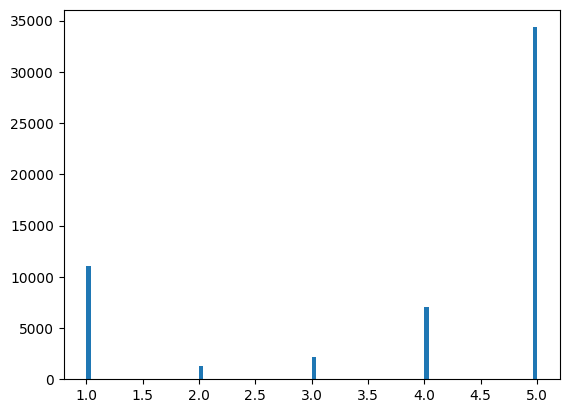

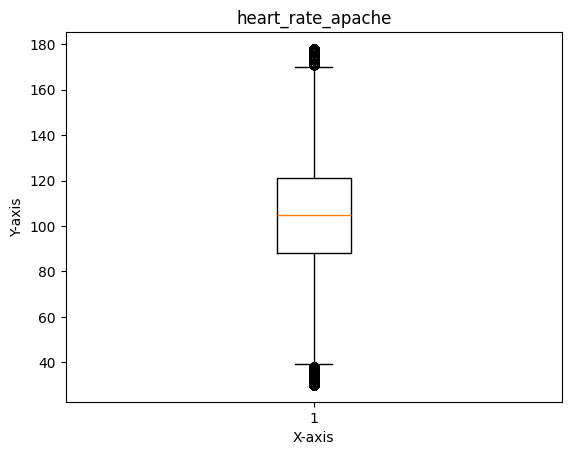

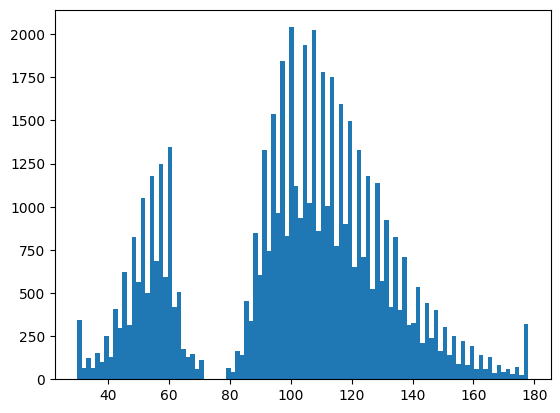

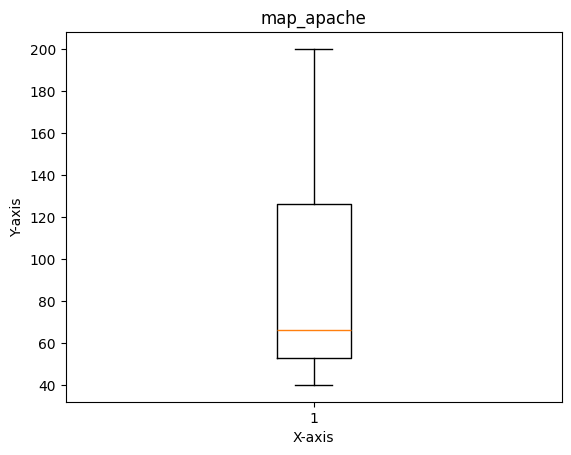

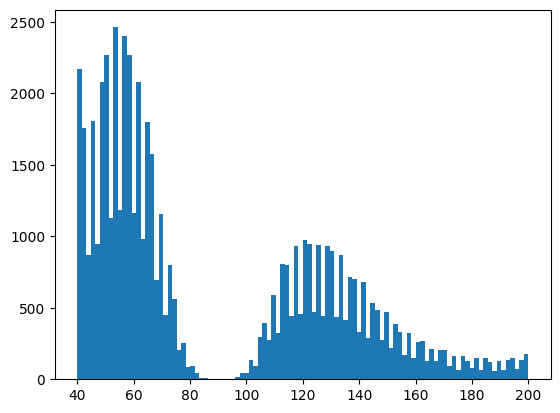

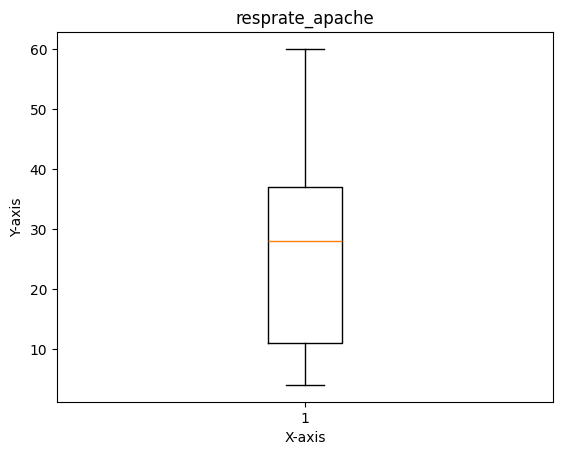

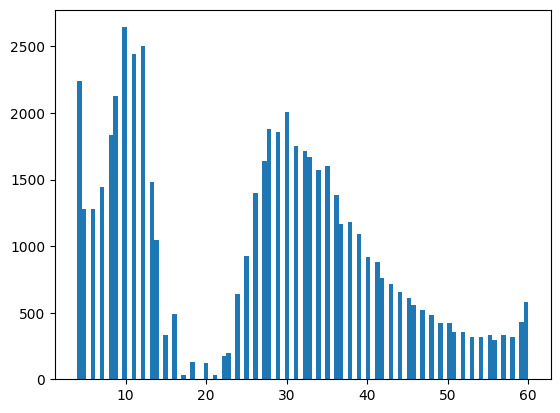

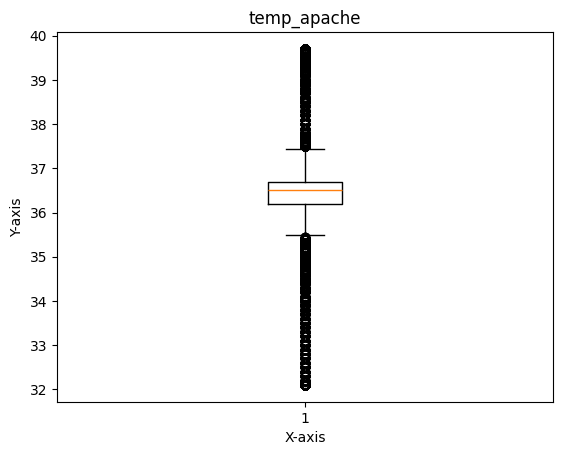

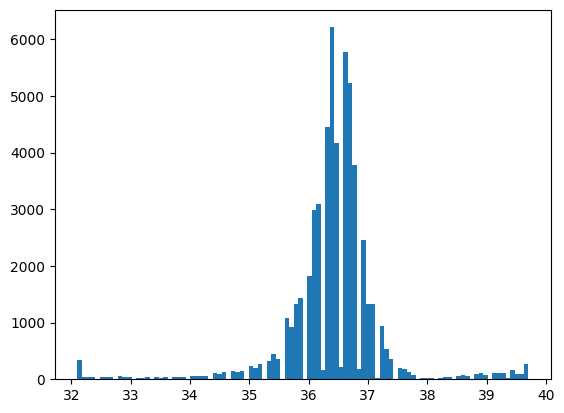

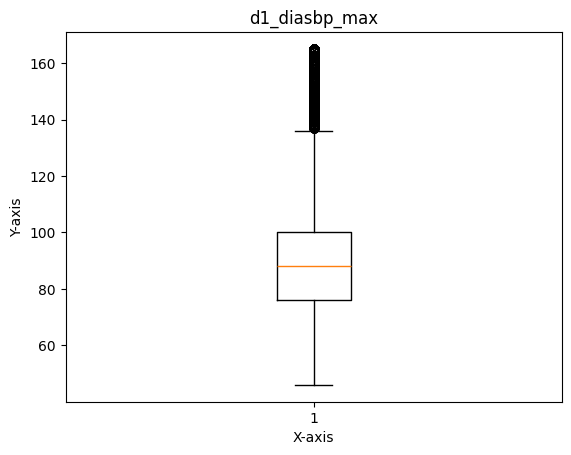

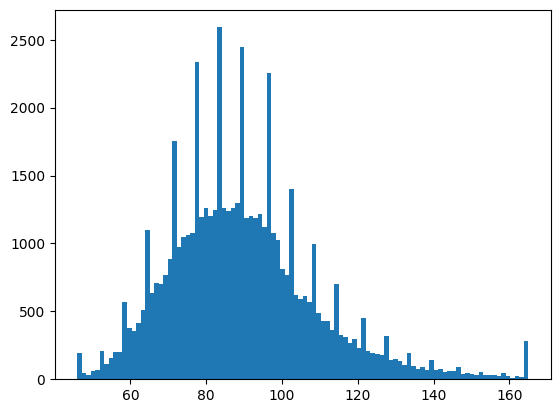

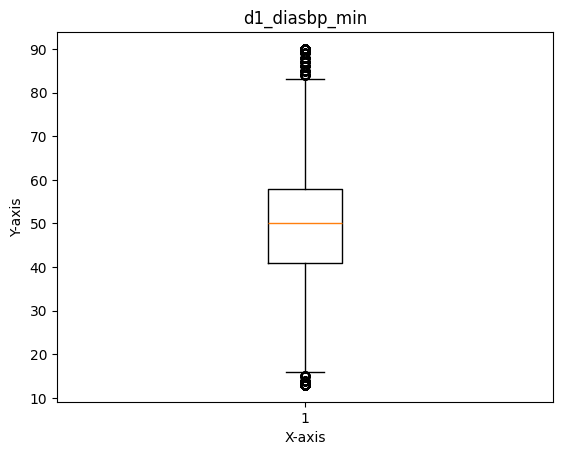

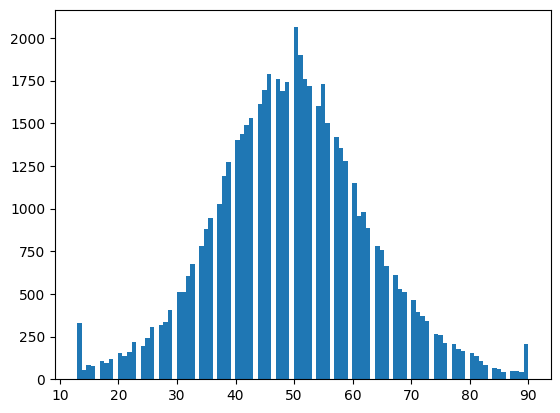

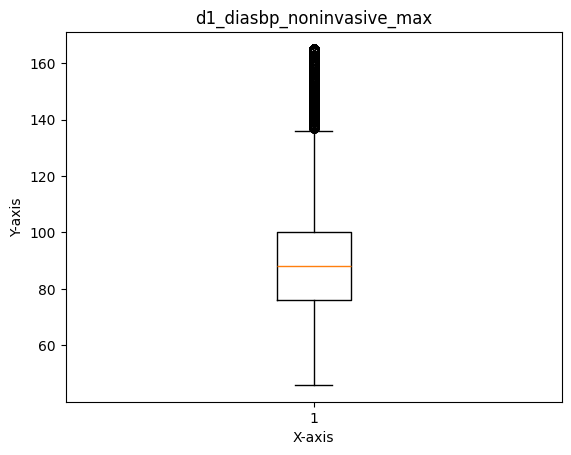

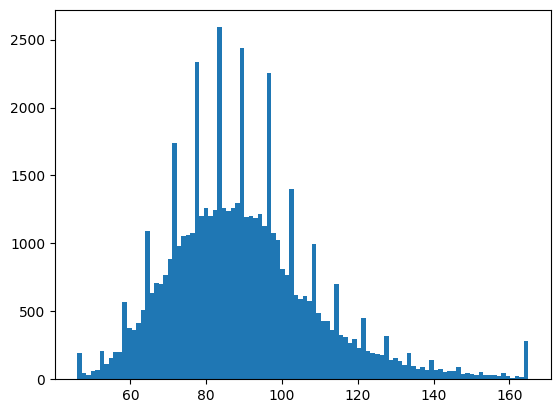

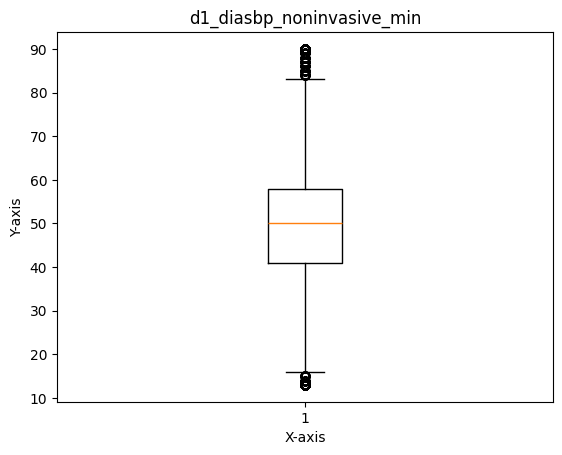

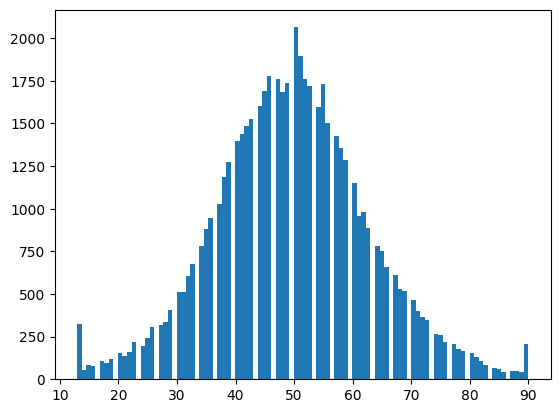

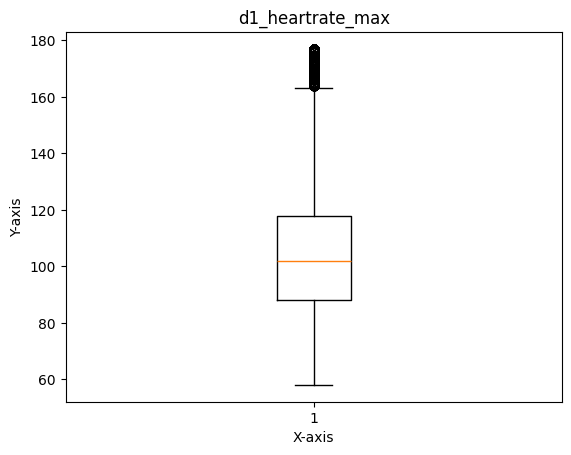

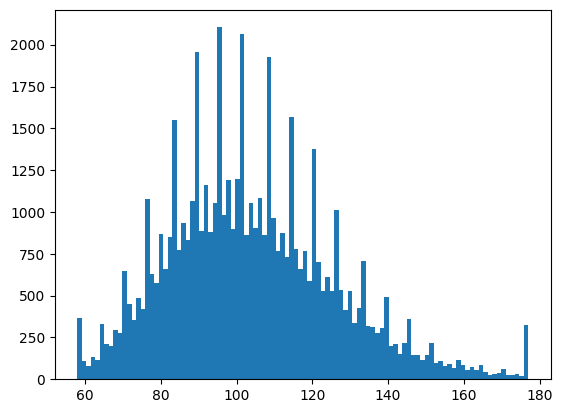

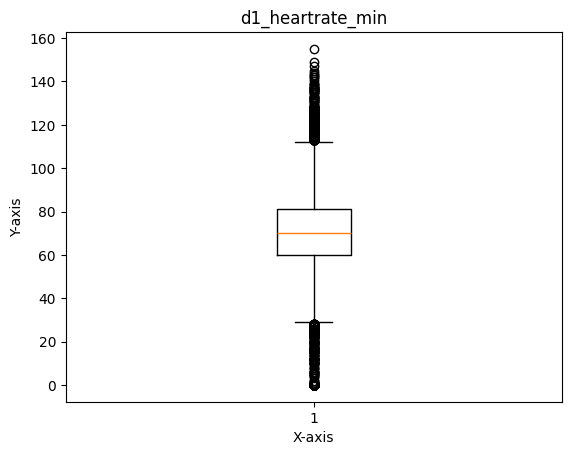

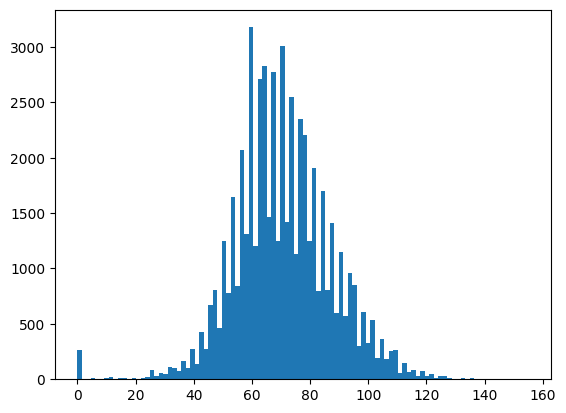

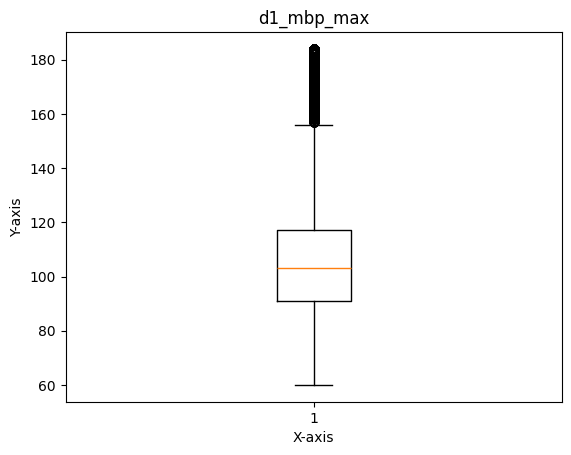

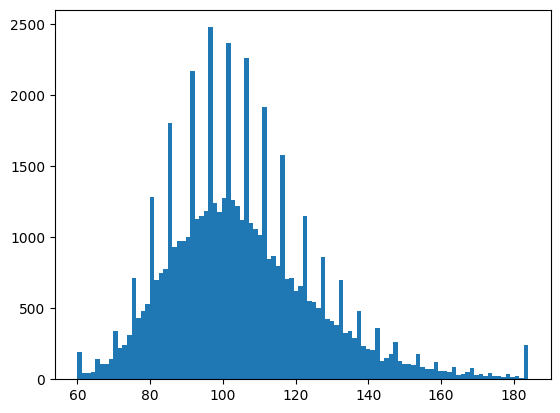

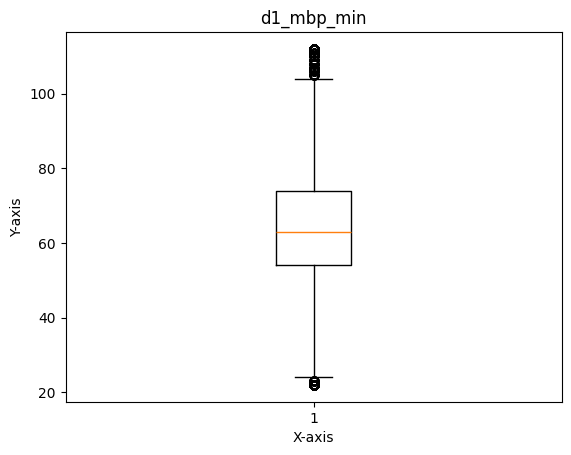

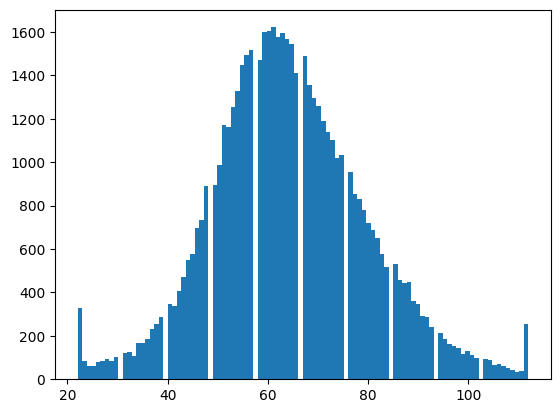

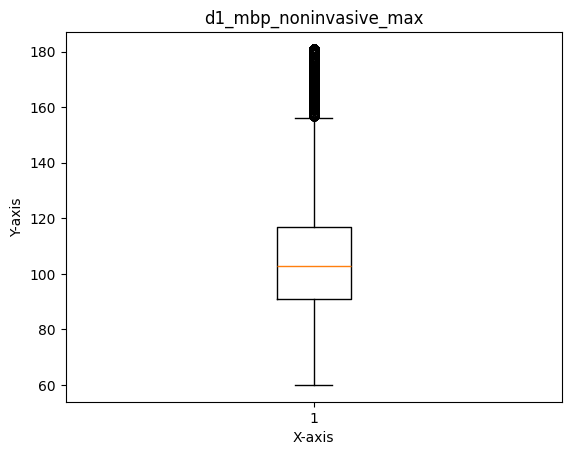

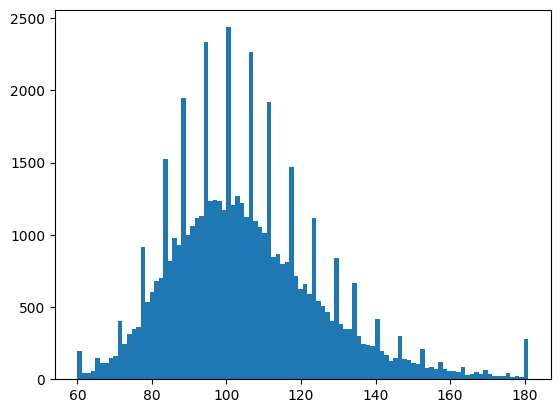

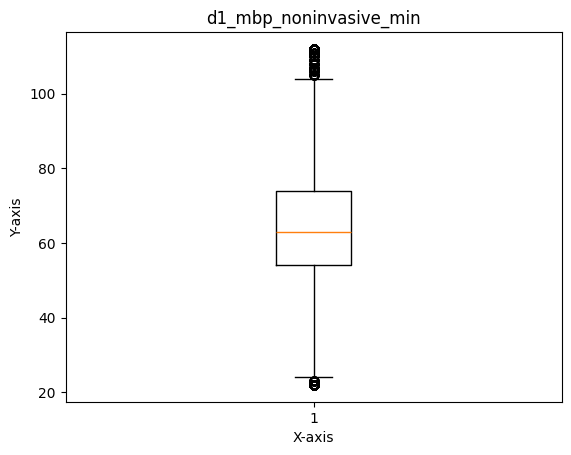

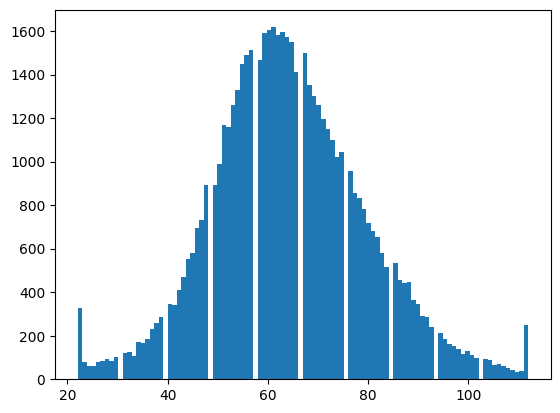

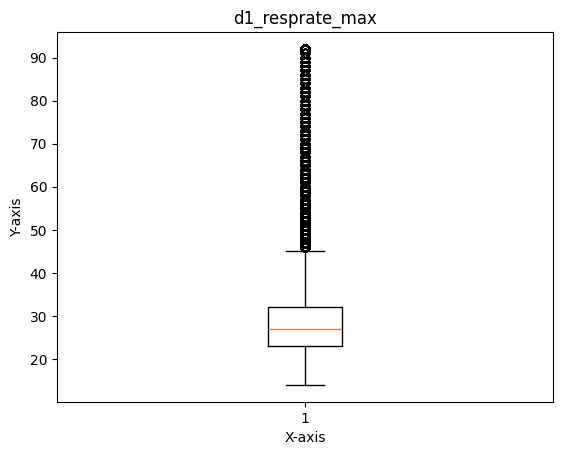

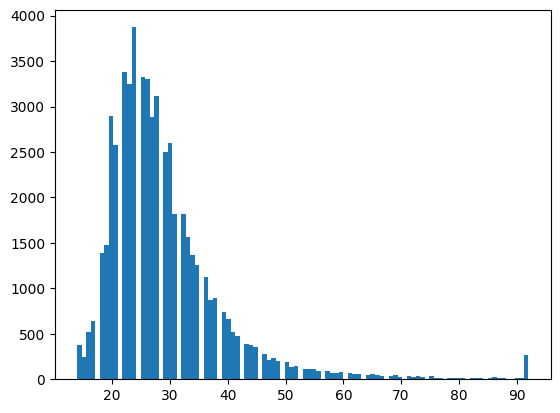

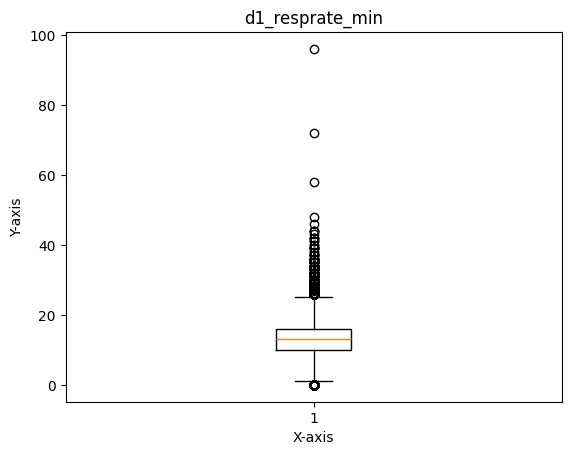

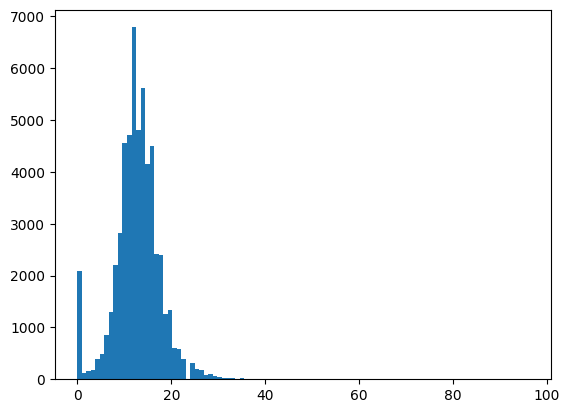

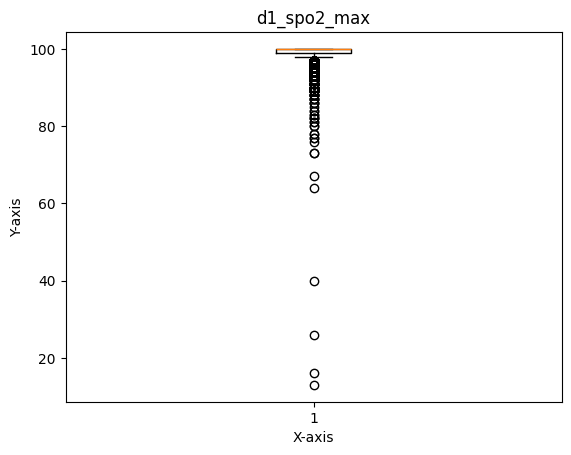

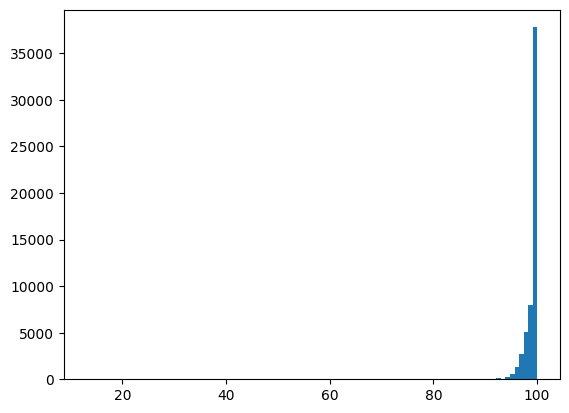

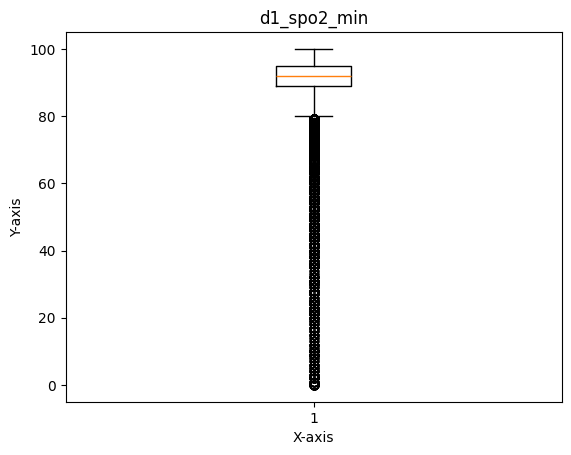

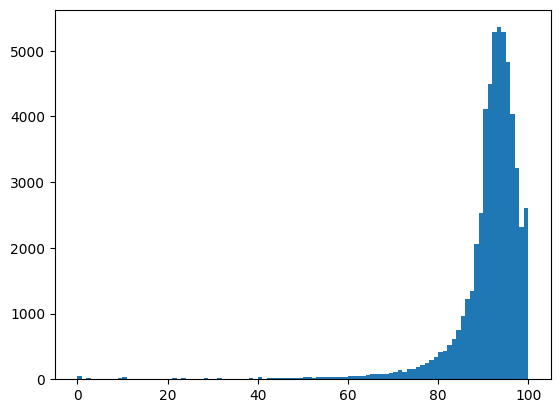

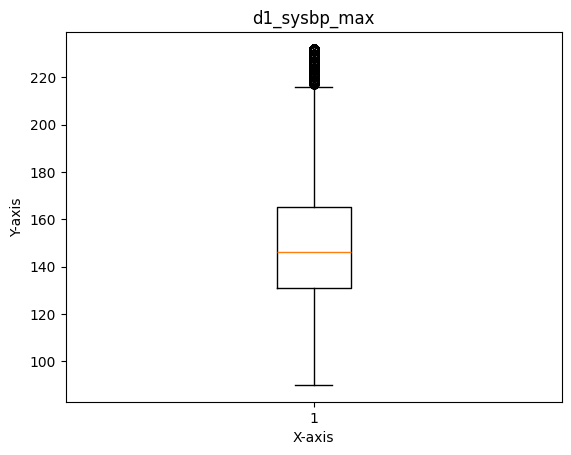

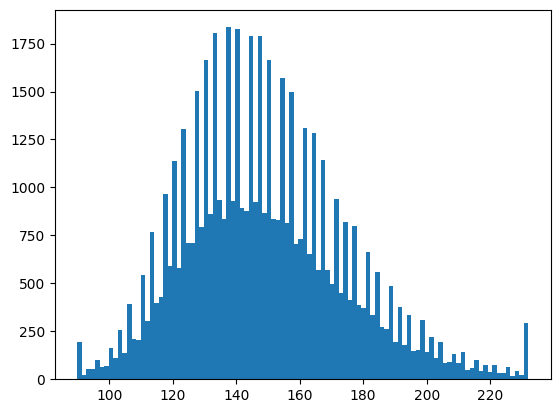

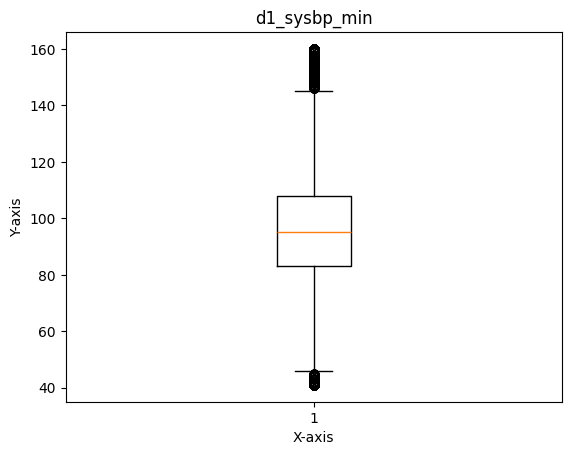

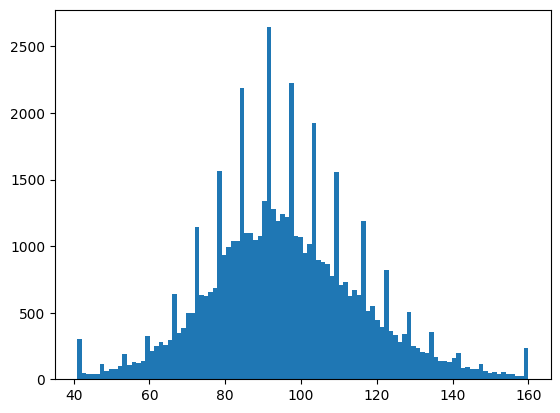

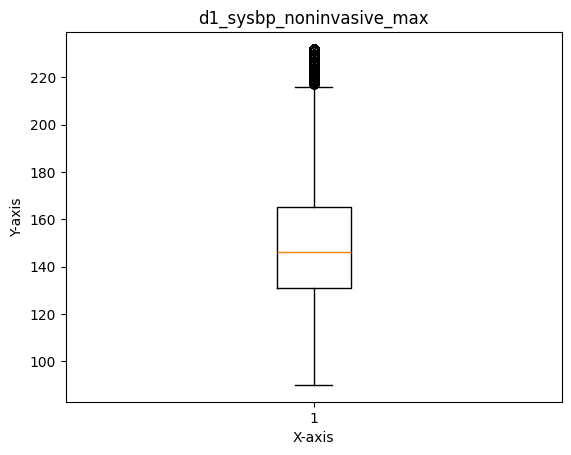

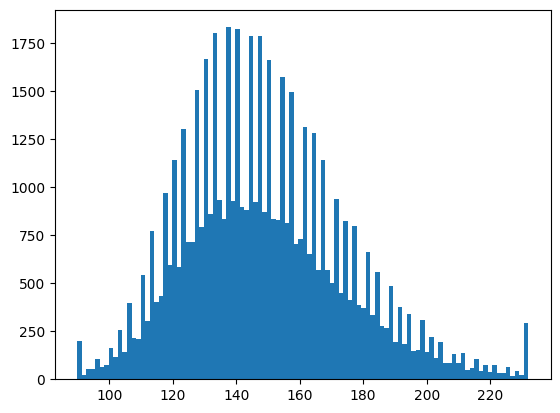

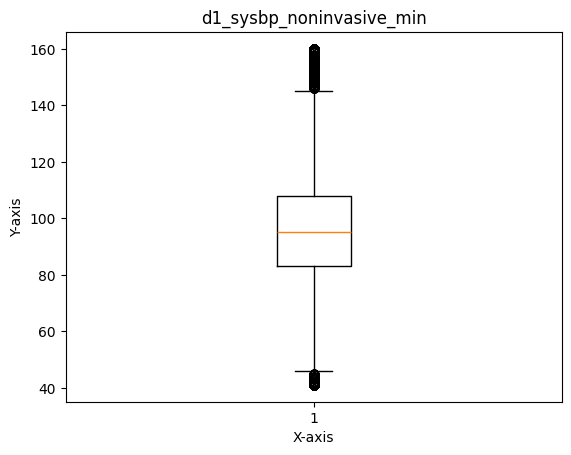

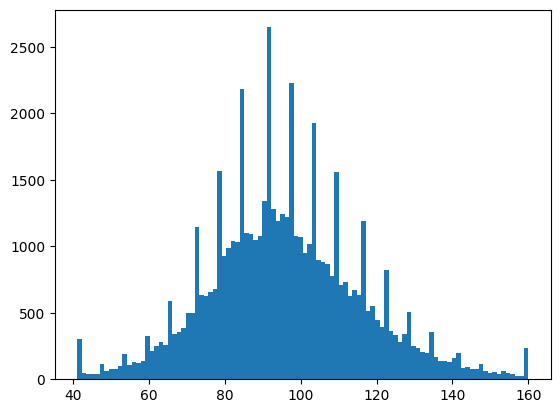

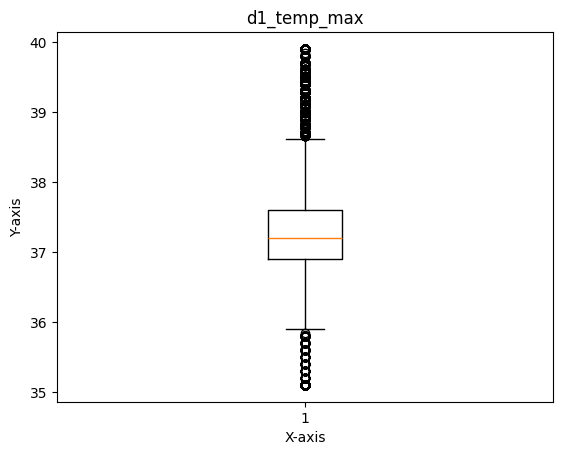

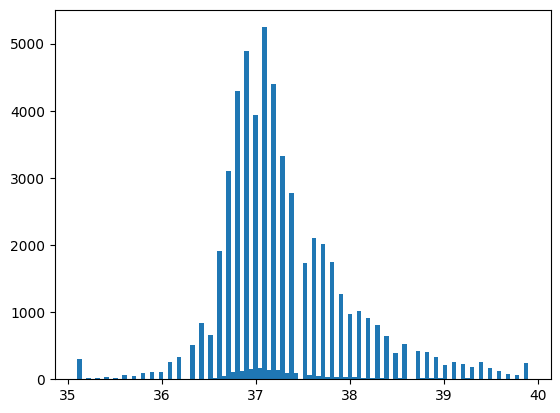

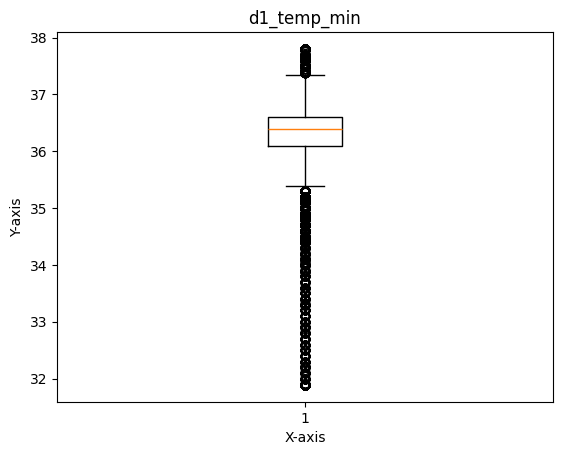

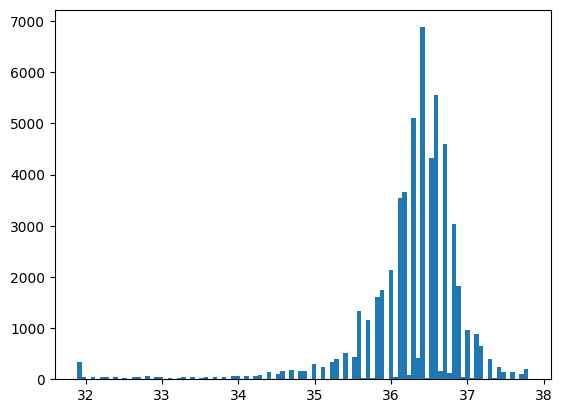

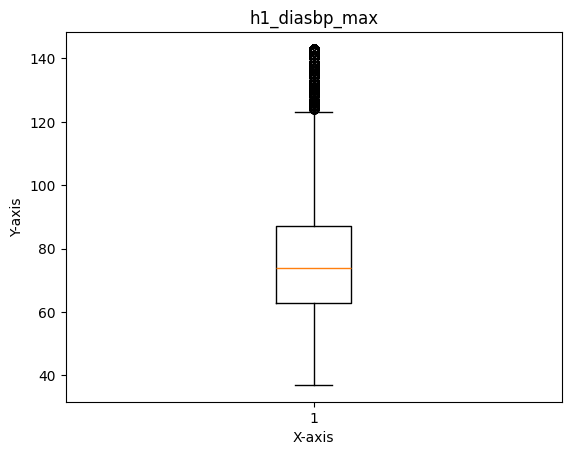

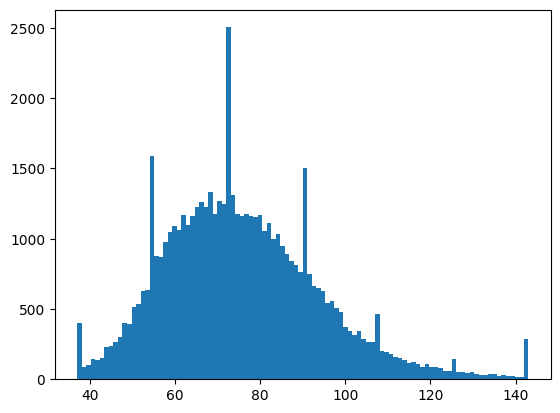

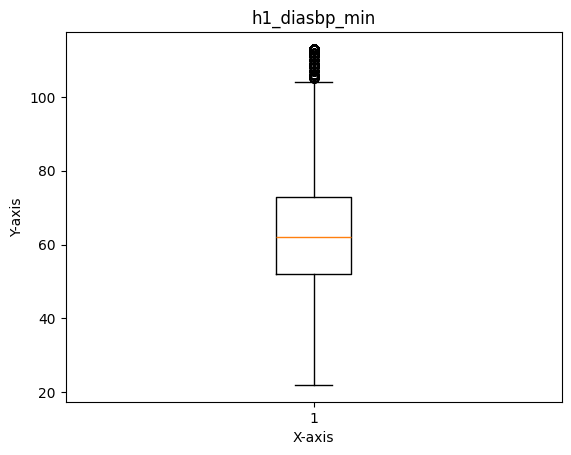

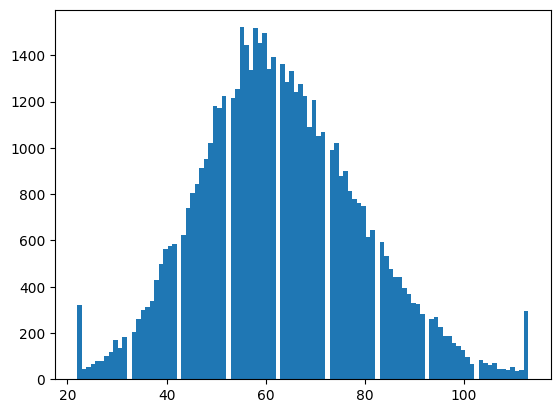

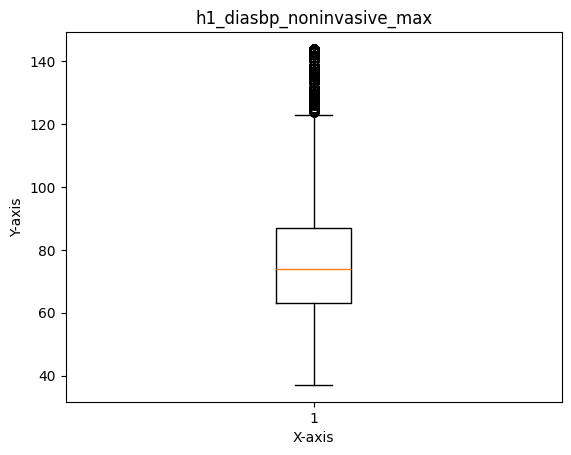

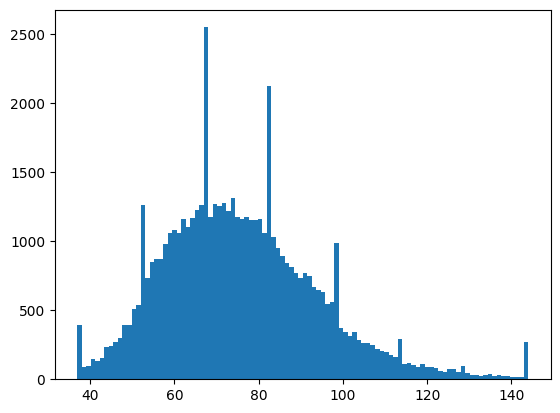

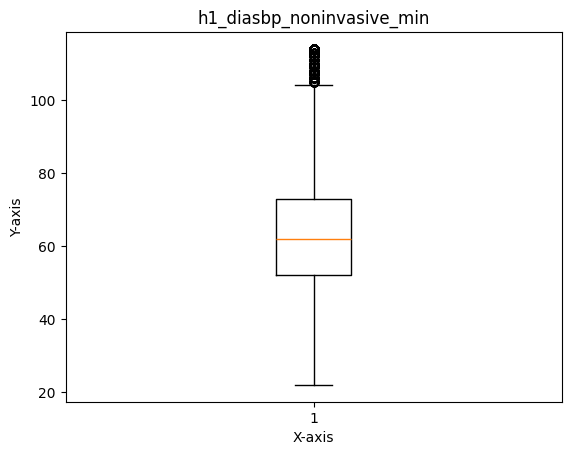

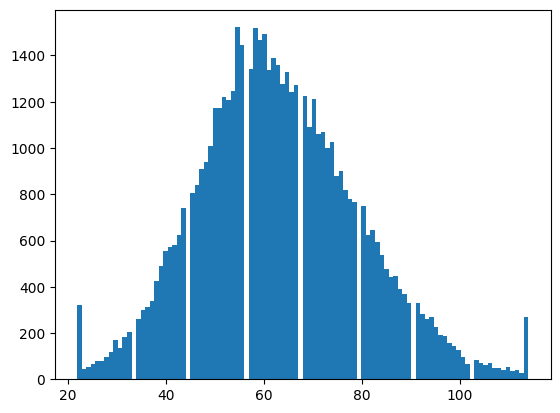

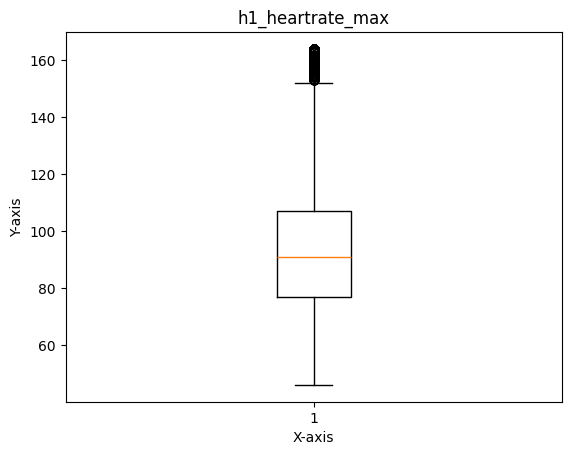

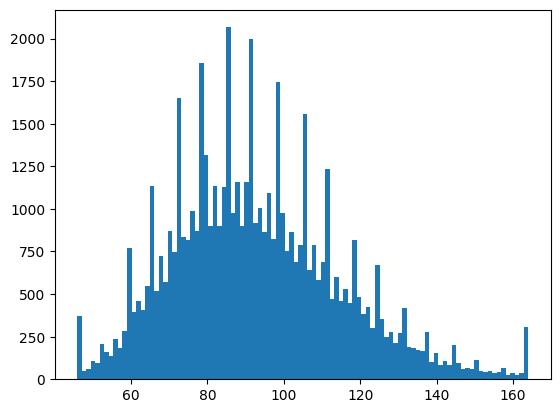

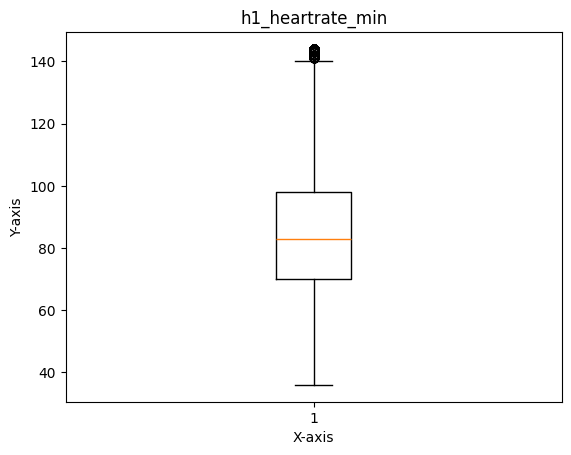

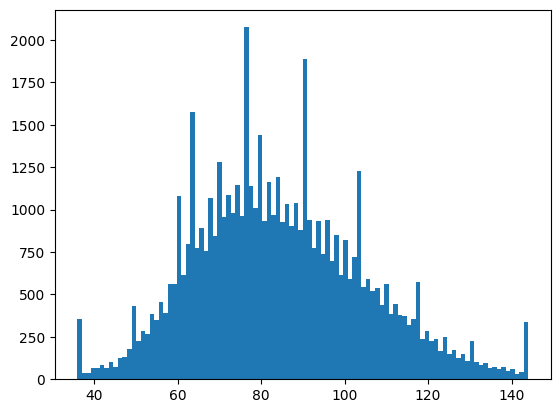

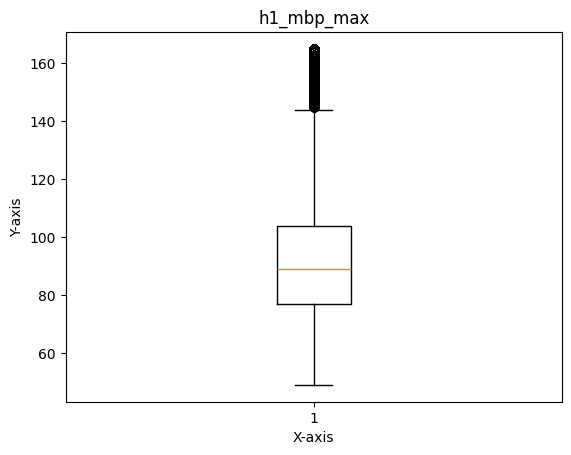

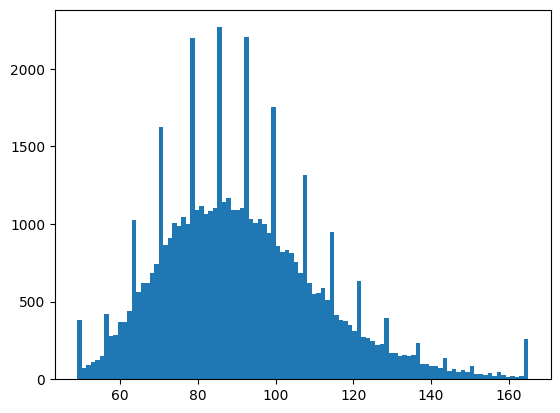

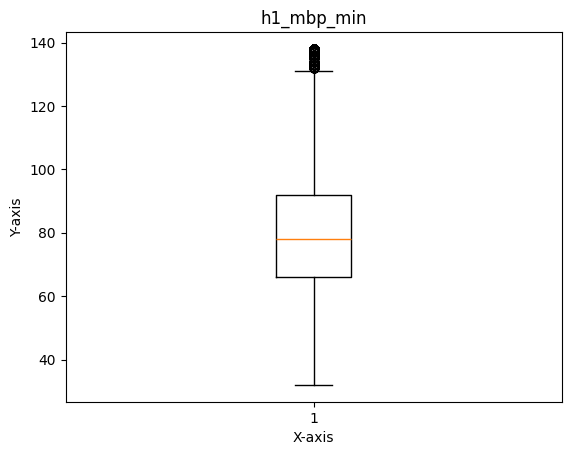

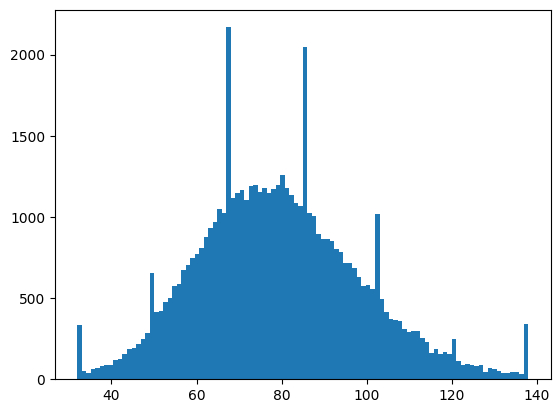

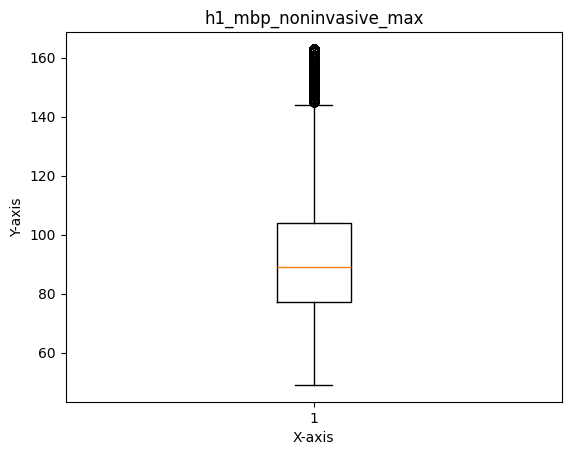

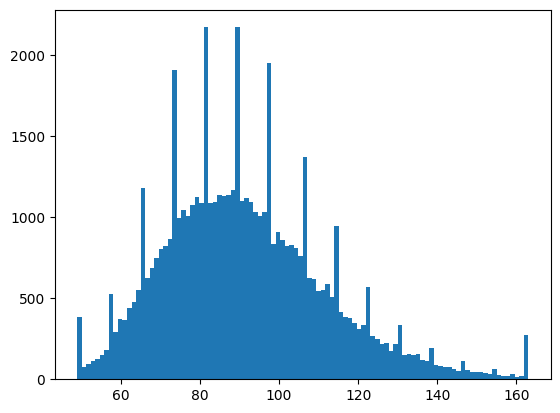

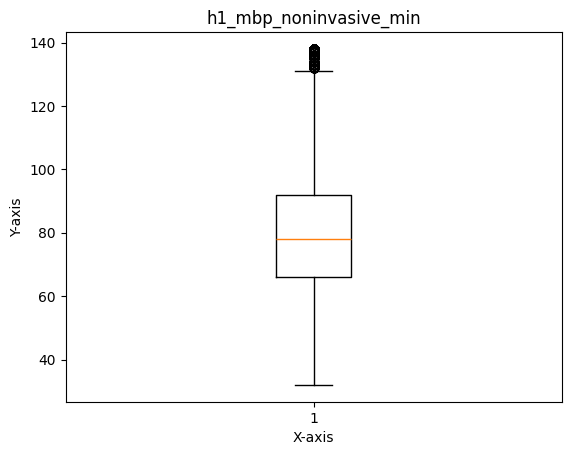

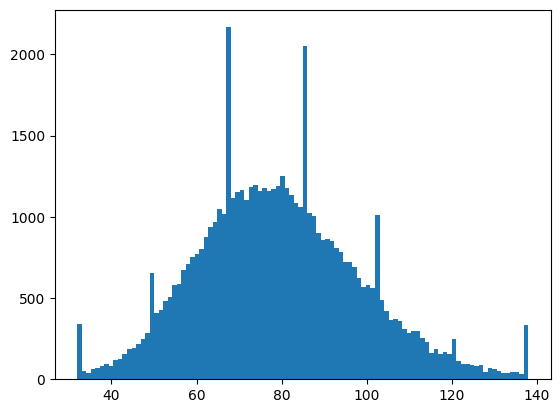

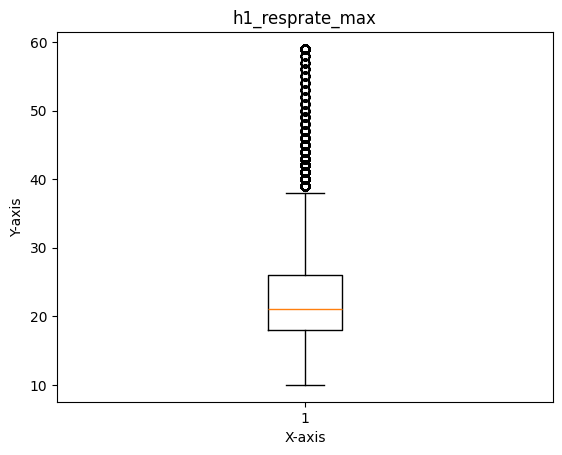

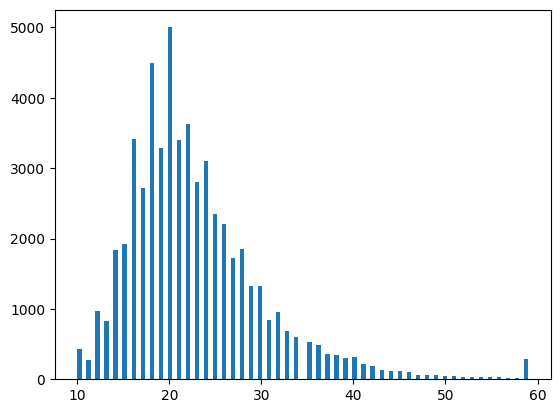

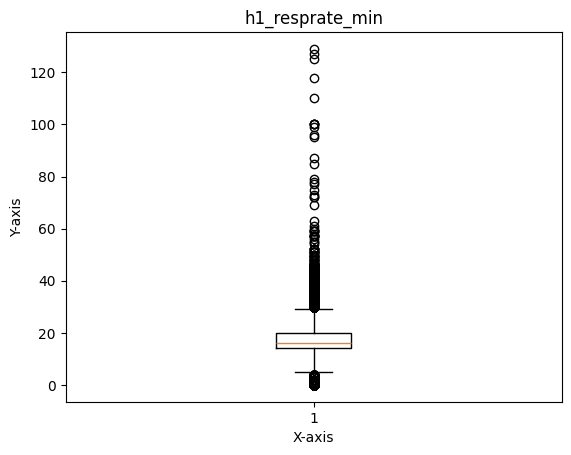

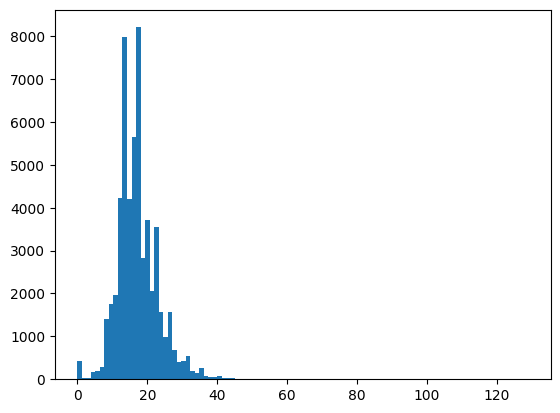

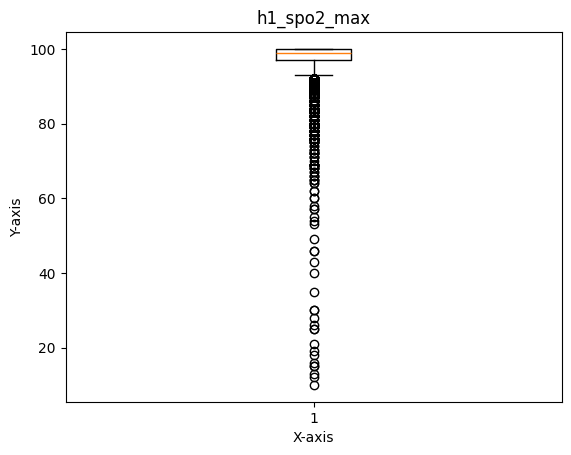

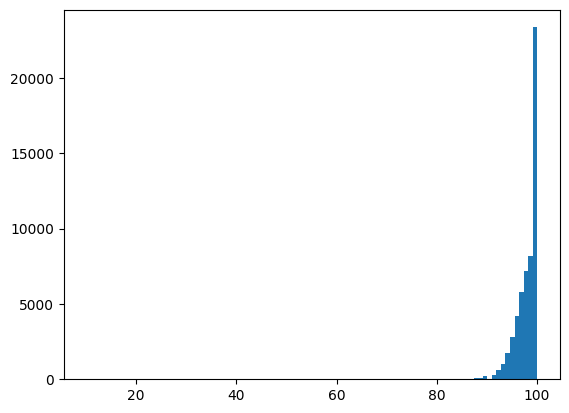

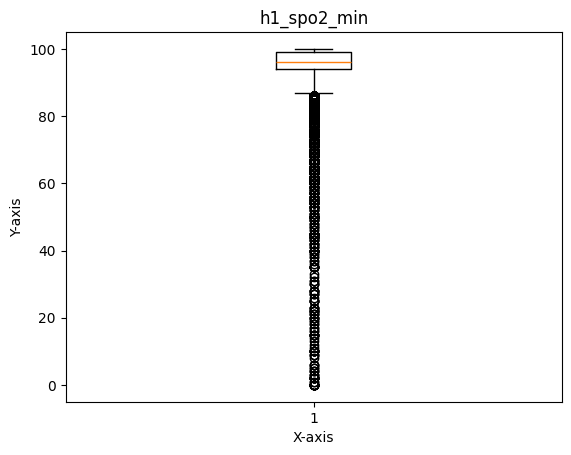

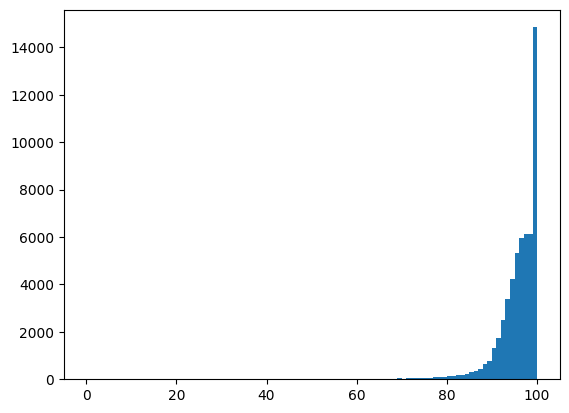

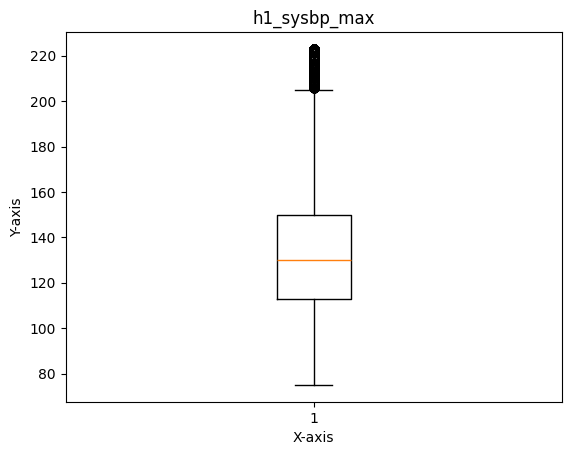

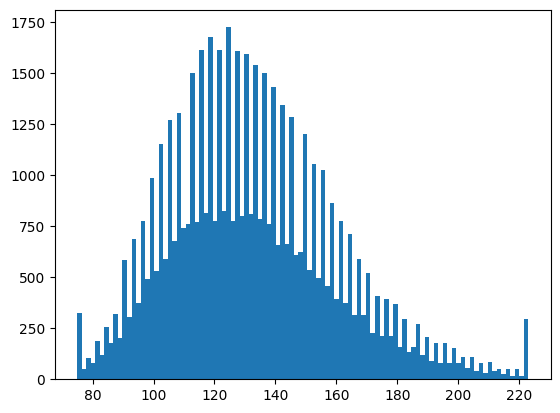

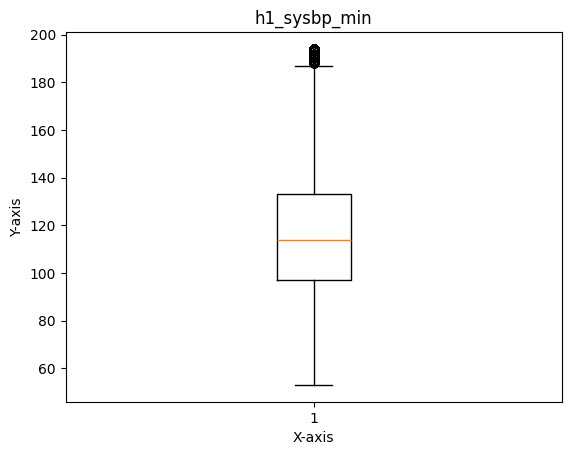

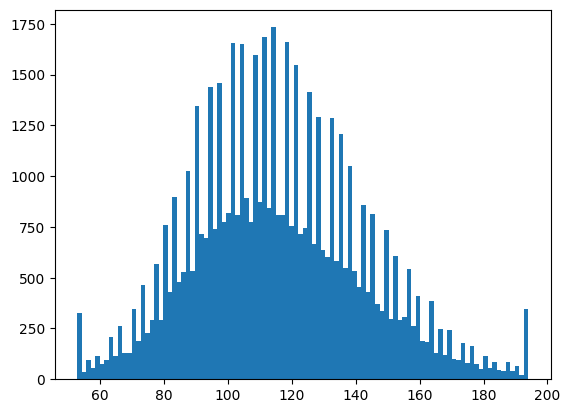

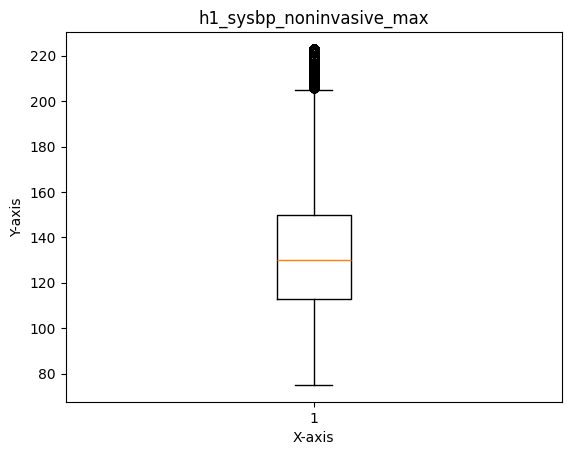

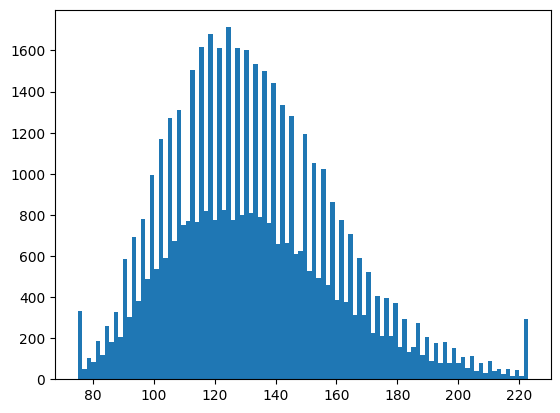

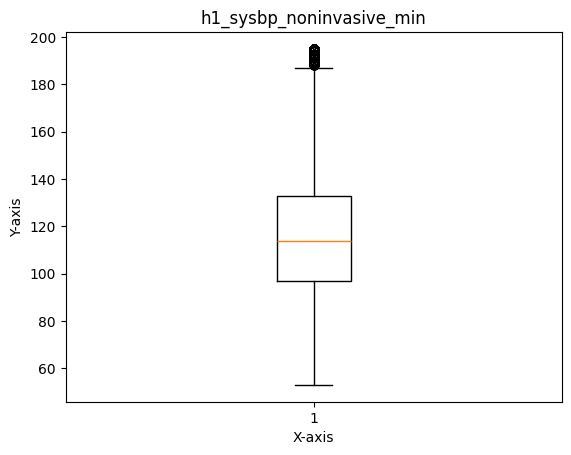

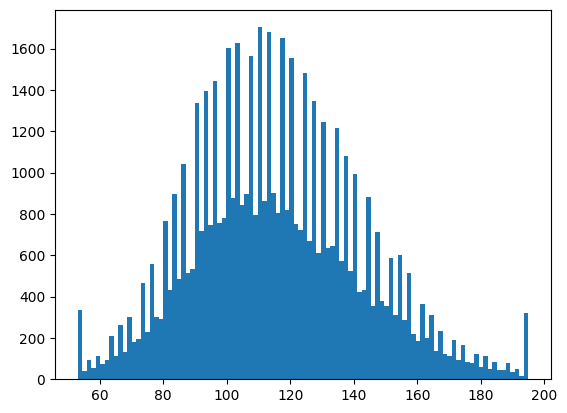

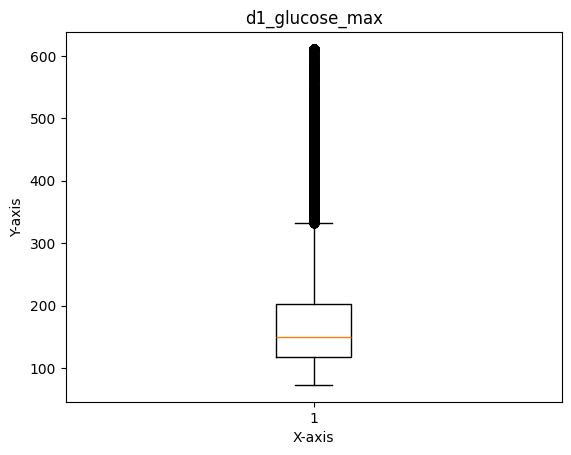

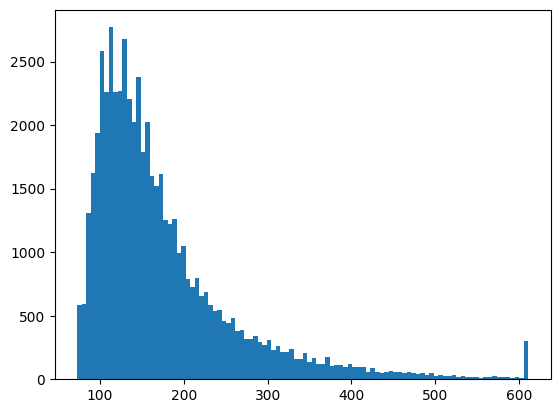

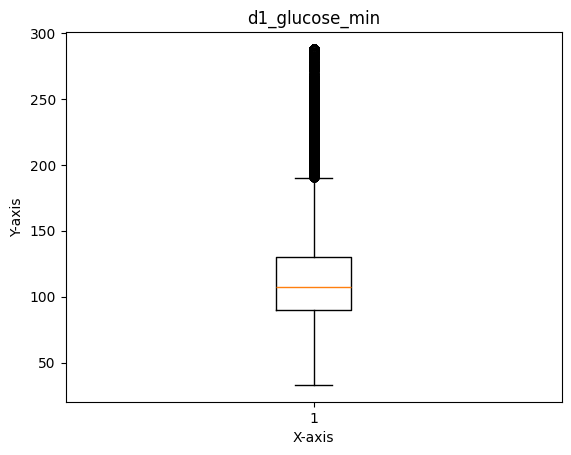

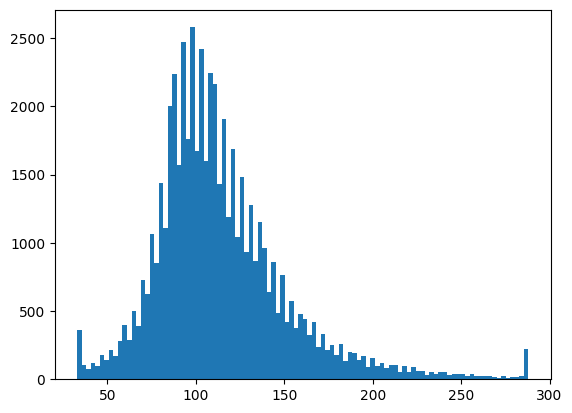

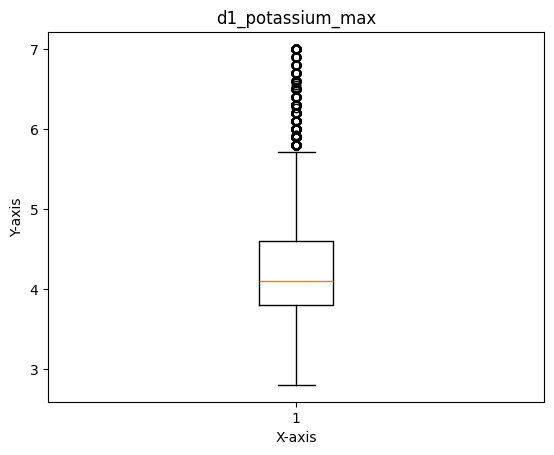

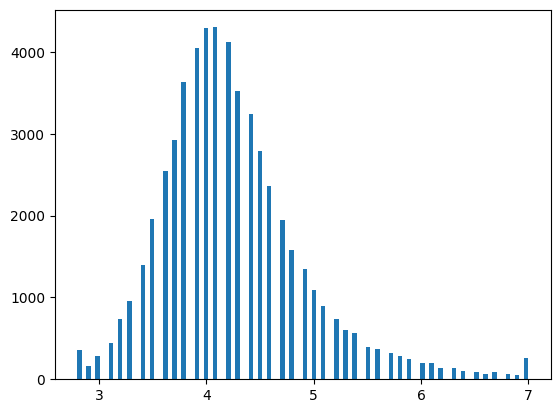

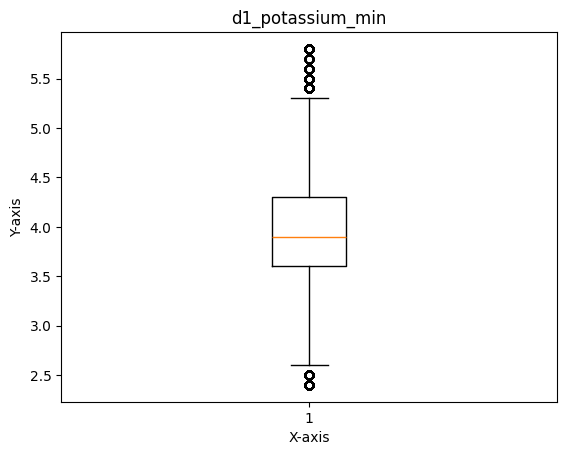

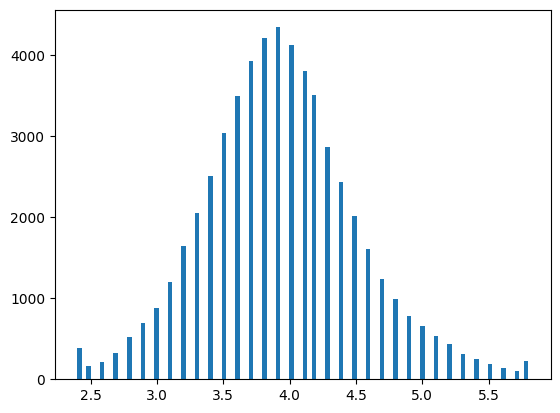

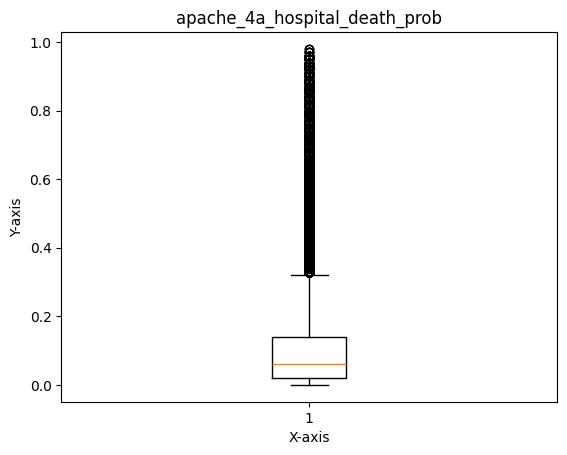

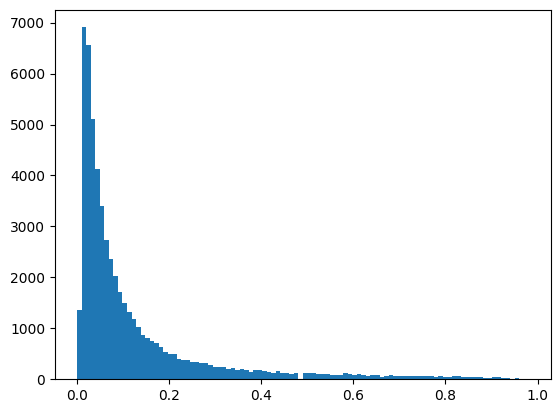

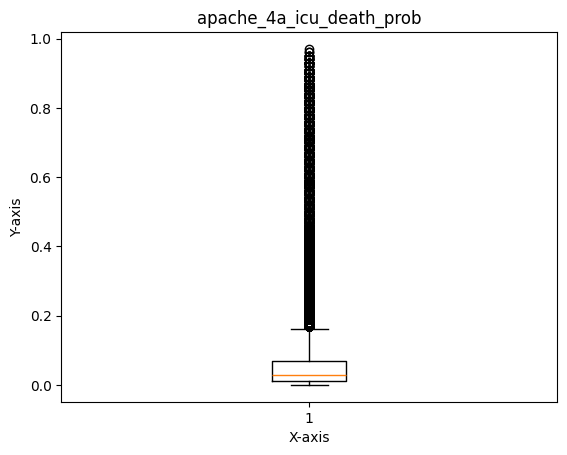

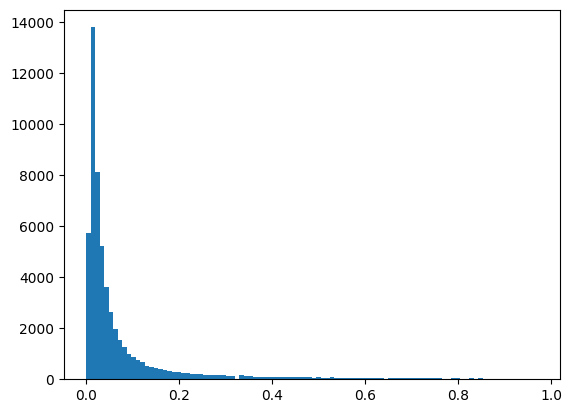

In [6]:
for col_name, dtypes in dataset_converted.dtypes.items():
    if dtypes != 'object' and len(dataset_converted[col_name].unique()) > 2:
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.title(col_name)
        plt.boxplot(dataset_converted[col_name])
        plt.show()
        plt.hist(dataset_converted[col_name], bins=100)
        plt.show()


In [7]:
num_columns = len(dataset_converted.columns)
print("Number of columns:", num_columns)

Number of columns: 111


In [8]:
# bmi_hospital_death_count = dataset_converted[['bmi', 'hospital_death', 'patient_id']].groupby(['bmi', 'hospital_death']).count()
# print(bmi_hospital_death_count)

# min_height = dataset_converted['height'].min()
# print(min_height)

# bmi_hospital_death_count = dataset_converted[['weight', 'hospital_death', 'patient_id']].groupby(['weight', 'hospital_death']).count()
# print(bmi_hospital_death_count)

# apache_4a_hospital_death_prob_min = dataset_converted['apache_4a_hospital_death_prob'].max()
# print(apache_4a_hospital_death_prob_min)

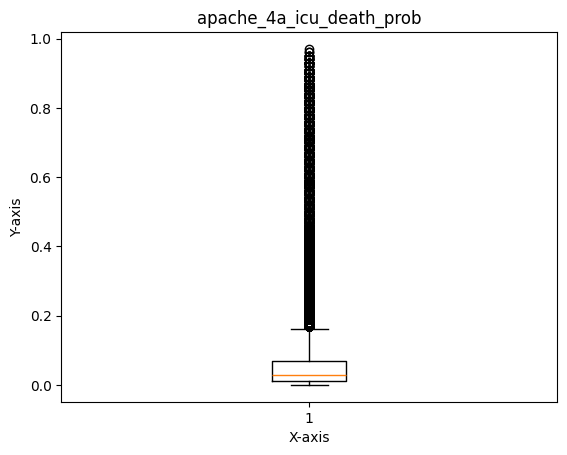

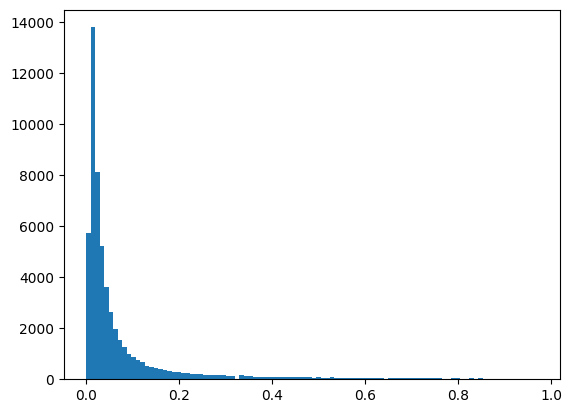

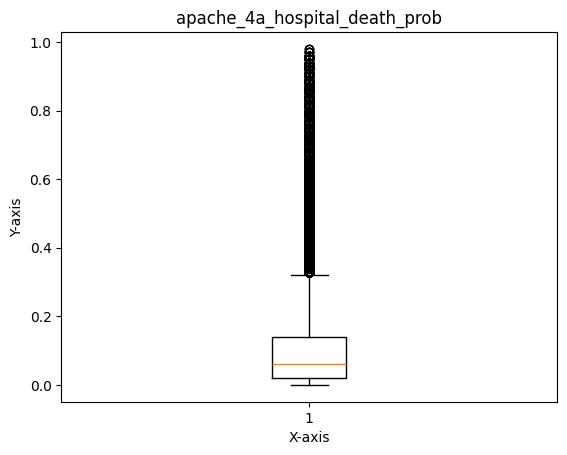

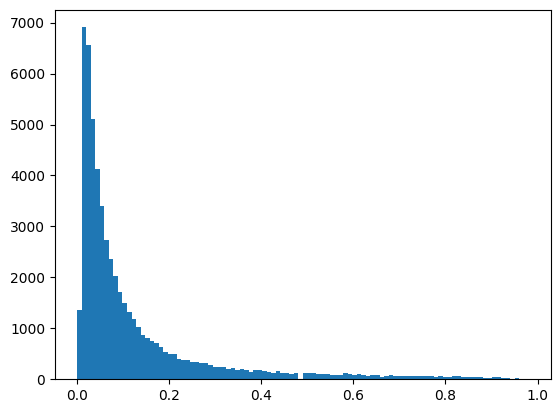

In [9]:
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title('apache_4a_icu_death_prob')
plt.boxplot(dataset_converted['apache_4a_icu_death_prob'])
plt.show()
plt.hist(dataset_converted['apache_4a_icu_death_prob'], bins=100)
plt.show()

plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title('apache_4a_hospital_death_prob')
plt.boxplot(dataset_converted['apache_4a_hospital_death_prob'])
plt.show()
plt.hist(dataset_converted['apache_4a_hospital_death_prob'], bins=100)
plt.show()



In [10]:
dataset_without_outliers_dataframe = spark.createDataFrame(dataset_converted)

# checking if duplicates exist
# count_before = dataset_without_outliers.count()
# df_no_duplicates = dataset_without_outliers.dropDuplicates().count()
# print(count_before, df_no_duplicates)

# for column in dataset_without_outliers_dataframe.columns:
#     if dataset_without_outliers_dataframe.filter(dataset_without_outliers_dataframe[column] == float('inf')).count() > 0:
#         print(f"There are infinity values in column '{column}'")
#     else:
#         print(f"No infinity values in column '{column}'")

In [11]:
'''
general info:
1) Unit vector normalization: Also known as vector normalization, this technique scales each data point so that the norm (magnitude) of the vector 
representing the data point is 1. It's often used in machine learning algorithms that calculate distances between data points, 
such as K-nearest neighbors (KNN) or Support Vector Machines (SVM).

2) Normalization is useful when there are no outliers as it cannot cope up with them

3) Usually, we would scale age and not incomes because only a few people have high incomes but the age is close to uniform.
'''

"\ngeneral info:\n1) Unit vector normalization: Also known as vector normalization, this technique scales each data point so that the norm (magnitude) of the vector \nrepresenting the data point is 1. It's often used in machine learning algorithms that calculate distances between data points, \nsuch as K-nearest neighbors (KNN) or Support Vector Machines (SVM).\n\n2) Normalization is useful when there are no outliers as it cannot cope up with them\n\n3) Usually, we would scale age and not incomes because only a few people have high incomes but the age is close to uniform.\n"

## Feature Engineering With Map Reduce - Logistic regression

In [15]:

# # add visiualziations and comments about what it benifited us in and make multiple types pie , bar and all scatterings and all , box plot and outliers 
# # presentation slides is essential and presentation is in the disscussion and make a script 
# # many models and compare accuracies and recalls and F1 scores is essential and u don't have to do it from scratch 
# # do report essential esential essential and make it rich and big and detailed step by step what u have done in the code clear and clarified 
# # map reduce one part and map and reduce function from scracth is essential and integernation benhom from scratch
# # any one has any questions ask hata lw haga msh fl manhag we all stressed 
# # discord after 8 ashal mn el mail 
# def my_map(func, iterable):
#     mapped_iterable = {}
#     threads = []
#     for idx, item in enumerate(iterable):
#         thread = threading.Thread(target=lambda: mapped_iterable.update({idx: func(item)}))
#         thread.start()
#         threads.append(thread)
#     for thread in threads:
#         thread.join()
#     return mapped_iterable

# def my_reduce(func, iterable):
#     result = {}
#     for item in iterable.values():
#         result = func(result, item)
#     return result

# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = LogisticRegression(random_state=42, max_iter=100000)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  

# def reduce_func(results):
#     y_true = []
#     y_pred = []

#     for key, value in results.items():
#         y, y_pred_chunk = value['data'] 
#         y_true.extend(y)
#         y_pred.extend(y_pred_chunk)

#     return {'results': (y_true, y_pred)} 


# data_pd = dataset_without_outliers_dataframe.toPandas()
# num_chunks = 4


# chunk_size = len(data_pd) // num_chunks
# remainder = len(data_pd) % num_chunks  
# start_index = 0
# chunks = []
# for i in range(num_chunks):
#         end_index = start_index + chunk_size
#         if i < remainder: 
#             end_index += 1
#         chunks.append(data_pd[start_index:end_index])
#         start_index = end_index


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# accuracy_LogisticRegression = accuracy_score(reduced_results['results'][0], reduced_results['results'][1])
# print("accuracy_LogisticRegression:", accuracy_LogisticRegression)




accuracy_LogisticRegression: 0.9038461538461539


### Map reduce threading

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# import threading


# def map_func(chunk, result_chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     classifier = LogisticRegression(random_state=42, max_iter=1000000)

#     pipeline = Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     pipeline.fit(x_train, y_train)

#     y_pred = pipeline.predict(x_test)
#     result_chunk.extend(list(zip(y_test, y_pred)))


# def reduce_func(results):
#     y_true = []
#     y_pred = []

#     for result_chunk in results:
#         for y, y_pred_chunk in result_chunk:
#             y_true.append(y)
#             y_pred.append(y_pred_chunk)

#     return y_true, y_pred

# if __name__ == '__main__':
    
#     data_pd = dataset_without_outliers_dataframe.toPandas()
#     print("len of data_pd: ", len(data_pd))
#     num_chunks = 4 

   
#     chunk_size = len(data_pd) // num_chunks
#     remainder = len(data_pd) % num_chunks  
#     start_index = 0
#     chunks = []
#     for i in range(num_chunks):
#         end_index = start_index + chunk_size
#         if i < remainder: 
#             end_index += 1
#         chunks.append(data_pd[start_index:end_index])
#         start_index = end_index


   
#     threads = []
#     mapped_results = []
#     for chunk in chunks:
#         result_chunk = []  
#         print("len of chunks: ", len(chunk))
#         thread = threading.Thread(target=map_func, args=(chunk, result_chunk))

#         threads.append(thread)
#         thread.start()
#         mapped_results.append(result_chunk)

    
#     for thread in threads:
#         thread.join()

    
#     reduced_results = reduce_func(mapped_results)

#     accuracy = accuracy_score(reduced_results[0], reduced_results[1])
#     print("Accuracy:", accuracy)


## Map reduce mrjob 

In [ ]:
    # from mrjob.job import MRJob
    # from mrjob.step import MRStep
    # from sklearn.model_selection import train_test_split
    # from sklearn.preprocessing import StandardScaler, OneHotEncoder
    # from sklearn.compose import ColumnTransformer
    # from sklearn.linear_model import LogisticRegression
    # from sklearn.metrics import accuracy_score

    # class PreprocessingJob(MRJob):
    #     def steps(self):
    #         return [
    #             MRStep(mapper_init=self.mapper_init,
    #                    mapper=self.mapper,
    #                    reducer=self.reducer)
    #         ]

    #     def mapper_init(self):
    #         # Load data and split into training and testing sets
    #         data_pd = dataset_without_outliers_dataframe.toPandas()
    #         self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(data_pd.drop('hospital_death', axis=1), 
    #                                                                                 data_pd['hospital_death'], 
    #                                                                                 test_size=0.2, 
    #                                                                                 random_state=42)

    #     def mapper(self, _, value):
    #         # Preprocess data
    #         numeric_transformer = StandardScaler()
    #         categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    #         numerical_cols = []
    #         categorical_cols = []

    #         data_pd = dataset_without_outliers_dataframe.toPandas()
    #         target = 'hospital_death'
    #         for col in data_pd.columns:
    #             if (col == target):
    #                 continue
    #             elif (data_pd[col].dtype == int) or (data_pd[col].dtype == float):
    #                 numerical_cols.append(col)
    #             else:
    #                 categorical_cols.append(col)

    #         preprocessor = ColumnTransformer(
    #             transformers=[
    #                 ('num', numeric_transformer, numerical_cols),
    #                 ('cat', categorical_transformer, categorical_cols)
    #             ])
    #         x_train_processed = preprocessor.fit_transform(self.x_train)
    #         x_test_processed = preprocessor.transform(self.x_test)
    #         yield None, (x_train_processed, x_test_processed, self.y_train, self.y_test)

    #     def reducer(self, _, values):
    #         # Train model and calculate accuracy
    #         for value in values:
    #             x_train, x_test, y_train, y_test = value
    #             classifier = LogisticRegression(random_state=42, max_iter=100000)
    #             classifier.fit(x_train, y_train)
    #             y_pred = classifier.predict(x_test)
    #             accuracy = accuracy_score(y_test, y_pred)
    #             yield None, accuracy

    # if __name__ == "__main__":
    #     PreprocessingJob.run()

# Feature engineering - Random Forest

In [20]:
# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = RandomForestClassifier(random_state=42)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# # Calculate accuracy, recall, and F1 score for Random Forest classifier
# y_true, y_pred = reduced_results['results']
# accuracy_randomForest = accuracy_score(y_true, y_pred)
# recall_randomForest = recall_score(y_true, y_pred)
# f1_randomForest = f1_score(y_true, y_pred)

# print("Random Forest Classifier Metrics:")
# print("Accuracy:", accuracy_randomForest)
# print("Recall:", recall_randomForest)
# print("F1 Score:", f1_randomForest)




Random Forest Classifier Metrics:
Accuracy: 0.9194096601073345
Recall: 0.1238390092879257
F1 Score: 0.21034180543382996


# Model Predection SVC

In [17]:
# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = SVC(random_state=42)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# accuracy_SVM = accuracy_score(reduced_results['results'][0], reduced_results['results'][1])
# print("accuracy_SVM:", accuracy_SVM)




accuracy_SVM: 0.9241502683363149


# Model Predection Gradient Boost

In [18]:
# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = GradientBoostingClassifier(random_state=42)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# accuracy_GradientBoosting = accuracy_score(reduced_results['results'][0], reduced_results['results'][1])
# print("accuracy_GradientBoosting:", accuracy_GradientBoosting)




accuracy_GradientBoosting: 0.9240608228980322


# Model Predection Descion trees

In [22]:
# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = DecisionTreeClassifier(random_state=42)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# # Calculate accuracy, recall, and F1 score for Decision Tree classifier
# y_true, y_pred = reduced_results['results']
# accuracy_decision_tree = accuracy_score(y_true, y_pred)
# recall_decision_tree = recall_score(y_true, y_pred)
# f1_decision_tree = f1_score(y_true, y_pred)

# print("Decision Tree Classifier Metrics:")
# print("Accuracy:", accuracy_decision_tree)
# print("Recall:", recall_decision_tree)
# print("F1 Score:", f1_decision_tree)



Decision Tree Classifier Metrics:
Accuracy: 0.8844364937388193
Recall: 0.3065015479876161
F1 Score: 0.3149522799575822


# KNN Classifier

In [25]:
# def map_func(chunk):
#     numerical_col = []
#     categorical_col = []

#     target = 'hospital_death'
#     for col in chunk.columns:
#         if col == target:
#             continue
#         elif chunk[col].dtype == int or chunk[col].dtype == float:
#             numerical_col.append(col)
#         else:
#             categorical_col.append(col)

#     numeric_transformer = StandardScaler()
#     categorical_transformer = OneHotEncoder(handle_unknown='ignore')

#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, numerical_col),
#             ('cat', categorical_transformer, categorical_col)
#         ], remainder='passthrough'
#     )

#     x = chunk.drop('hospital_death', axis=1)
#     y = chunk['hospital_death']

#     x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#     classifier = KNeighborsClassifier(n_neighbors=10)
#     MyPipeline= Pipeline([
#         ('preprocessor', preprocessor),
#         ('classifier', classifier)
#     ])
#     MyPipeline.fit(x_train, y_train)

#     y_pred = MyPipeline.predict(x_test)

#     return {'data': (y_test, y_pred)}  


# mapped_results = my_map(map_func, chunks)
# reduced_results = reduce_func(mapped_results)

# # Calculate accuracy, recall, and F1 score for KNN classifier
# y_true, y_pred = reduced_results['results']
# accuracy_knn = accuracy_score(y_true, y_pred)
# recall_knn = recall_score(y_true, y_pred)
# f1_knn = f1_score(y_true, y_pred)

# print("K-Nearest Neighbors (KNN) Classifier Metrics:")
# print("Accuracy:", accuracy_knn)
# print("Recall:", recall_knn)
# print("F1 Score:", f1_knn)


K-Nearest Neighbors (KNN) Classifier Metrics:
Accuracy: 0.920304114490161
Recall: 0.15273477812177502
F1 Score: 0.2493681550126369


# Gather Models

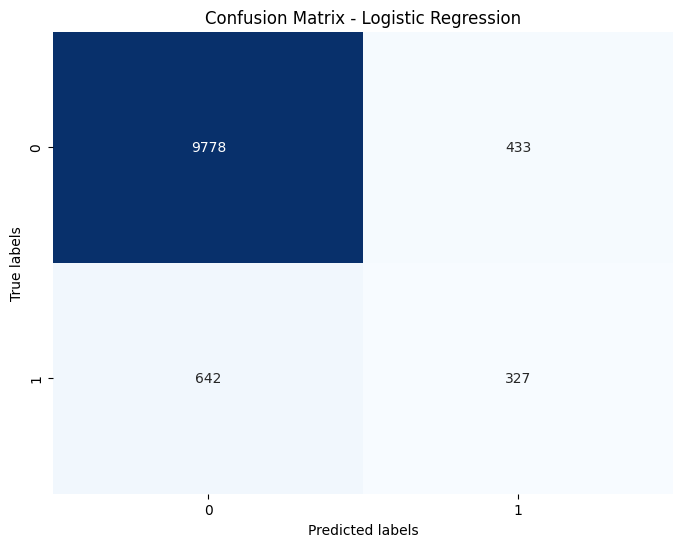

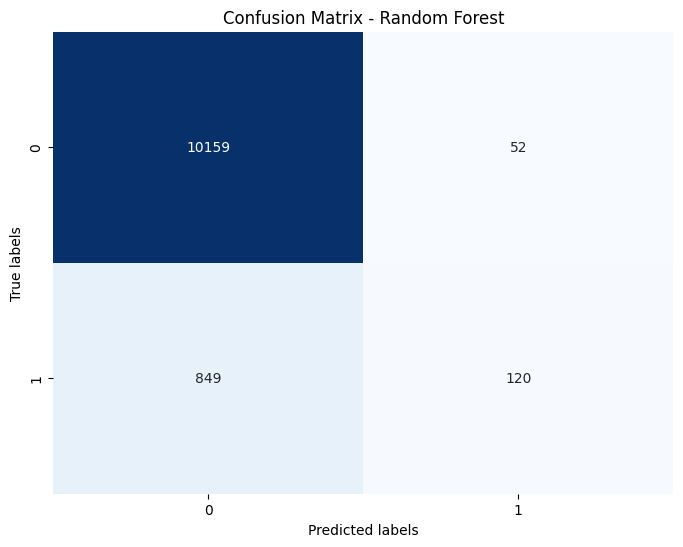

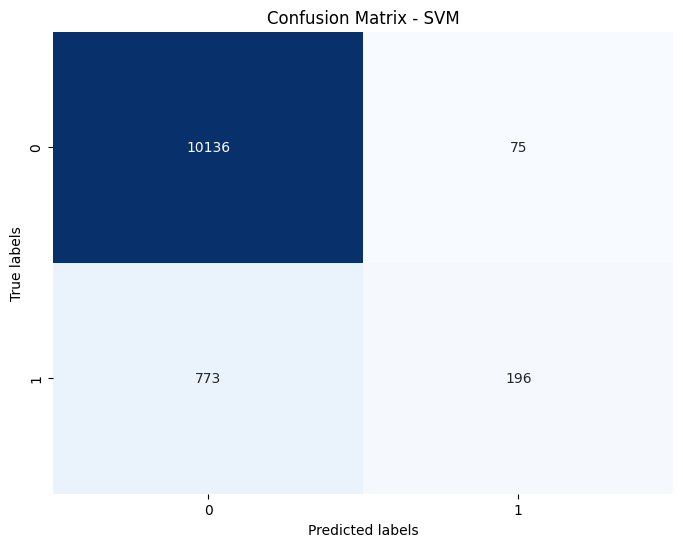

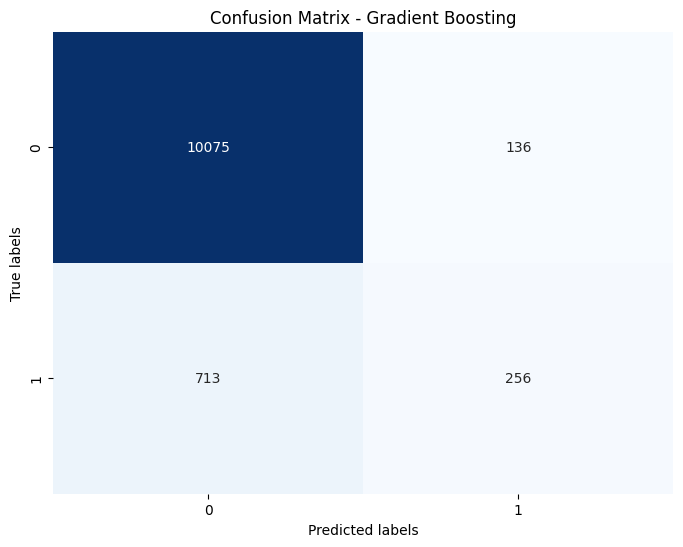

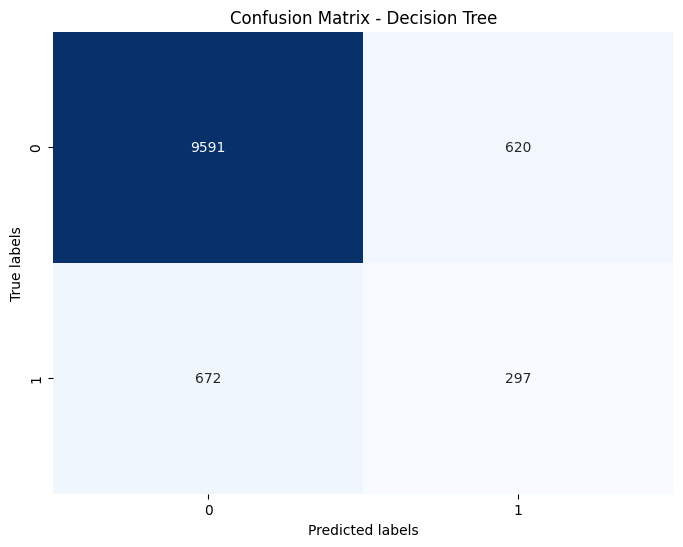

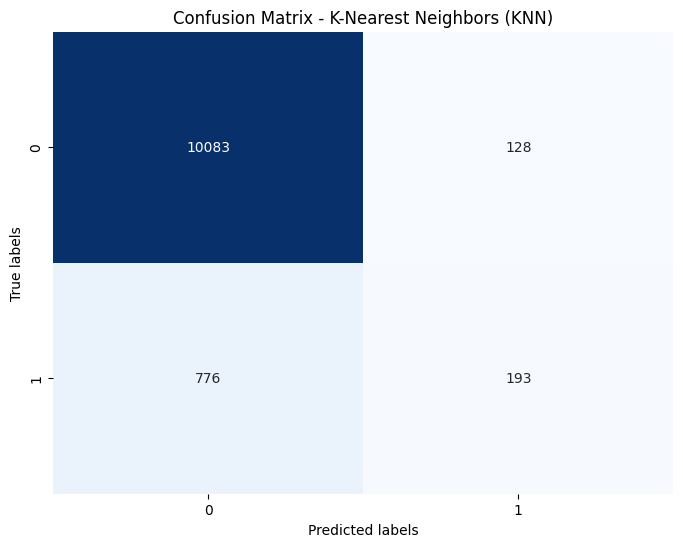

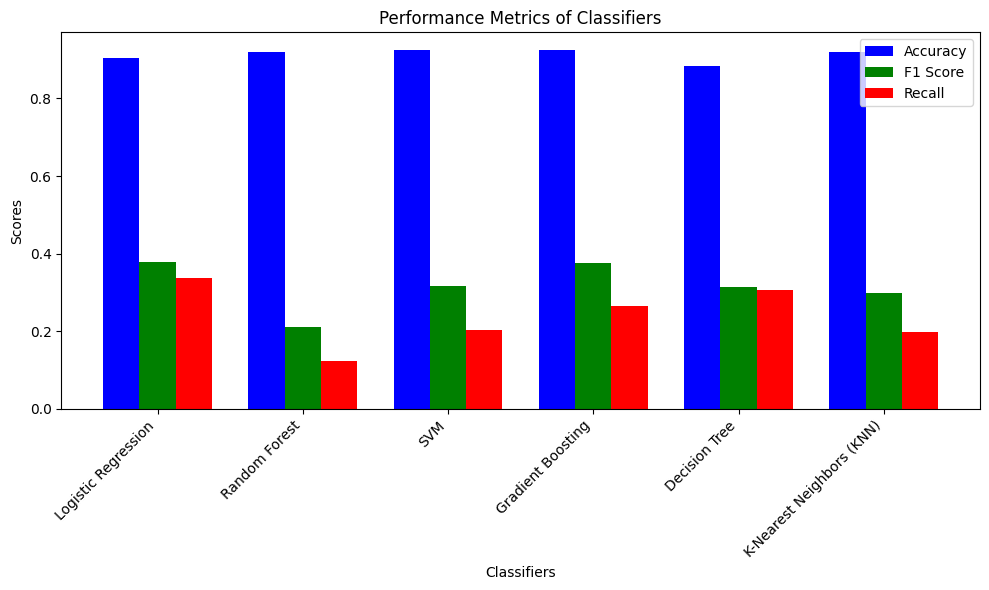

In [41]:
import numpy as np

def my_map(func, iterable):
    mapped_iterable = {}
    lock = threading.Lock()

    def update_result(idx, result):
        with lock:
            mapped_iterable[idx] = result

    threads = []
    for idx, item in enumerate(iterable):
        thread = threading.Thread(target=update_result, args=(idx, func(*item)))
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()
    return mapped_iterable


def map_func(chunk, classifier):
    numerical_col = []
    categorical_col = []

    target = 'hospital_death'
    for col in chunk.columns:
        if col == target:
            continue
        elif chunk[col].dtype == int or chunk[col].dtype == float:
            numerical_col.append(col)
        else:
            categorical_col.append(col)

    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_col),
            ('cat', categorical_transformer, categorical_col)
        ], remainder='passthrough'
    )

    x = chunk.drop('hospital_death', axis=1)
    y = chunk['hospital_death']

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    MyPipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    MyPipeline.fit(x_train, y_train)

    y_pred = MyPipeline.predict(x_test)

    return {'data': (y_test, y_pred)}  



def my_reduce(func, iterable):
    result = {}
    for item in iterable.values():
        result = func(result, item)
    return result

def reduce_func(results):
    y_true = []
    y_pred = []

    for key, value in results.items():
        y, y_pred_chunk = value['data'] 
        y_true.extend(y)
        y_pred.extend(y_pred_chunk)

    return {'results': (y_true, y_pred)} 

classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=100000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(n_neighbors=5)
}



data_pd = dataset_without_outliers_dataframe.toPandas()
num_chunks = 4


chunk_size = len(data_pd) // num_chunks
remainder = len(data_pd) % num_chunks  
start_index = 0
chunks = []
for i in range(num_chunks):
        end_index = start_index + chunk_size
        if i < remainder: 
            end_index += 1
        chunks.append(data_pd[start_index:end_index])
        start_index = end_index

def plot_confusion_matrix(y_true, y_pred, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.show()
accuracy_values = []
f1_values = []
recall_values = []

for classifier_name, classifier in classifiers.items():
    mapped_results = my_map(map_func, [(chunk, classifier) for chunk in chunks])
    reduced_results = reduce_func(mapped_results)
    y_true, y_pred = reduced_results['results']
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy_values.append(accuracy)
    f1_values.append(f1)
    recall_values.append(recall)
    plot_confusion_matrix(y_true, y_pred, classifier_name)



# Define the classifiers as the x-axis labels
classifiers_list = list(classifiers.keys())


x = np.arange(len(classifiers_list))


bar_width = 0.25


plt.figure(figsize=(10, 6))


plt.bar(x - bar_width, accuracy_values, width=bar_width, label='Accuracy', color='b')
plt.bar(x, f1_values, width=bar_width, label='F1 Score', color='g')
plt.bar(x + bar_width, recall_values, width=bar_width, label='Recall', color='r')


plt.xlabel('Classifiers')
plt.ylabel('Scores')
plt.title('Performance Metrics of Classifiers')
plt.xticks(x, classifiers_list, rotation=45, ha='right')
plt.legend()
plt.tight_layout()


plt.show()